<a href="https://colab.research.google.com/github/Sauryashri822/Data-Analysis-Projects/blob/main/Vender_performance_project_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vendor Performance Project

In [59]:
# import requried  modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sqlalchemy import create_engine
import logging
import time

# Configure logging to capture information and errors during data ingestion
logging.basicConfig(
    filename='logs/ingestion_db.log',
    level=logging.DEBUG,
    format='%(asctime)s-%(levelname)s-%(message)s',
    filemode='a')

# Create an SQLite database engine. The database file will be named 'sqlite' and stored in '/content/'
engine = create_engine('sqlite:////content/sqlite')

# Define a function to ingest a pandas DataFrame into a specified table in the database
def ingest_db(df, tabel_name, engain):
      '''this function will ingest the dataframe into database tabel'''
      df.to_sql(tabel_name,con=engain,if_exists="replace",index=False)

# Define a function to load raw CSV data from the '/content/' directory and ingest it into the database
def load_raw_data():
  '''this function will load the CSVs as dataframe and ingest into db '''
  start=time.time() # Record the start time for performance measurement
  for file in os.listdir('/content/'): # Iterate through all files in the content directory
          if '.csv'in file: # Check if the file is a CSV
            # Added on_bad_lines='skip' to handle parsing errors by skipping problematic lines
            try:
                # Read the CSV file into a DataFrame, skipping bad lines to prevent errors
                df=pd.read_csv('/content/'+file, on_bad_lines='skip')
                print(f"Successfully loaded {file} with shape {df.shape}") # Print successful load message
                ingest_db(df,file[:-4],engine) # Ingest the DataFrame into the SQLite database
            except Exception as e:
                logging.error(f"Error loading {file}: {e}") # Log any errors during file loading
                print(f"Error loading {file}: {e}") # Print error message to console
  end=time.time() # Record the end time
  total_time=(end-start)/60 # Calculate total ingestion time in minutes
  logging.info('Ingestion Complete') # Log completion of ingestion
  logging.info(f'\nTotal Time Taken:{total_time}minutes') # Log total time taken

# Call load_raw_data() once to ingest data when the cell is run
load_raw_data()

Successfully loaded sales.csv with shape (279708, 14)
Successfully loaded purchases.csv with shape (228226, 16)
Successfully loaded vendor_invoice.csv with shape (5543, 10)
Successfully loaded purchase_prices.csv with shape (12261, 9)
Successfully loaded begin_inventory.csv with shape (206529, 9)
Successfully loaded end_inventory.csv with shape (224489, 9)


# EDA

understanding the dataset to explore how the data is present in the database and if there is a need of creating some  agragated tabel that can help with ;
- Vender selection for profitability
- Product Pricing Optimization

In [118]:
import sqlite3

# creating database connection to interact with the SQLite database
conn = sqlite3.connect('/content/sqlite')

In [61]:
# checking tables present in the database by querying the sqlite_master table
tables = pd.read_sql_query("""SELECT name AS 'Table name' FROM sqlite_master WHERE type = 'table';""",conn)
tables # Display the list of tables

,Table name
0,sales
1,purchases
2,vendor_invoice
3,purchase_prices
4,begin_inventory
5,end_inventory


In [62]:
tables = pd.read_sql_query("""SELECT name AS 'Table name' FROM sqlite_master WHERE type = 'table';""",conn)
display(tables) # Display the list of tables using display() for better formatting

,Table name
0,sales
1,purchases
2,vendor_invoice
3,purchase_prices
4,begin_inventory
5,end_inventory


In [63]:
for table in tables ['Table name']:
  print('-'*50,f'{table}','-'*50) # Print a separator for readability
  # Get and print the count of records for each table
  print('count of records:',pd.read_sql(f'select count(*)as count from {table}',conn)['count'].values[0])
  # Display the first 5 rows of each table to get a preview of the data
  display(pd.read_sql(f'select * from {table} limit 5',conn))

-------------------------------------------------- sales --------------------------------------------------
count of records: 279708


,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1.0,16.49,16.49,2024-01-01,750.0,1.0,0.79,12546.0,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2.0,32.98,16.49,2024-01-02,750.0,1.0,1.57,12546.0,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1.0,16.49,16.49,2024-01-03,750.0,1.0,0.79,12546.0,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1.0,14.49,14.49,2024-01-08,750.0,1.0,0.79,12546.0,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2.0,69.98,34.99,2024-01-09,375.0,1.0,0.79,12546.0,JIM BEAM BRANDS COMPANY


-------------------------------------------------- purchases --------------------------------------------------
count of records: 228226


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2023-12-21,2024-01-02,2024-01-04,2024-02-16,35.71,6.0,214.26,1.0
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,4.0,37.40,1.0
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-02,2024-01-07,2024-02-21,9.41,5.0,47.05,1.0
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2023-12-22,2024-01-01,2024-01-07,2024-02-21,9.35,6.0,56.10,1.0
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2023-12-24,2024-01-02,2024-01-09,2024-02-16,21.32,5.0,106.60,1.0


-------------------------------------------------- vendor_invoice --------------------------------------------------
count of records: 5543


,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2024-01-04,8124,2023-12-21,2024-02-16,6,214.26,3.47,None
1,4466,AMERICAN VINTAGE BEVERAGE,2024-01-07,8137,2023-12-22,2024-02-21,15,140.55,8.57,None
2,388,ATLANTIC IMPORTING COMPANY,2024-01-09,8169,2023-12-24,2024-02-16,5,106.60,4.61,None
3,480,BACARDI USA INC,2024-01-12,8106,2023-12-20,2024-02-05,10100,137483.78,2935.20,None
4,516,BANFI PRODUCTS CORP,2024-01-07,8170,2023-12-24,2024-02-12,1935,15527.25,429.20,None


-------------------------------------------------- purchase_prices --------------------------------------------------
count of records: 12261


,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.


-------------------------------------------------- begin_inventory --------------------------------------------------
count of records: 206529


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2024-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2024-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2024-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2024-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2024-01-01


-------------------------------------------------- end_inventory --------------------------------------------------
count of records: 224489


,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2024-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2024-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2024-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2024-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2024-12-31


In [64]:
purchases = pd.read_sql_query("SELECT * FROM purchases", conn) # Load the purchases table into a DataFrame
# Group by Brand and PurchasePrice, then sum Quantity and Dollars to see purchase patterns
purchases.groupby(['Brand','PurchasePrice'])[['Quantity','Dollars']].sum()

,,Quantity,Dollars
Brand,PurchasePrice,,
58,9.28,338.0,3136.64
61,10.60,36.0,381.60
62,28.67,260.0,7454.20
63,30.46,212.0,6457.52
70,13.96,11.0,153.56
...,...,...,...
47027,5.29,143.0,756.47
47075,6.23,12.0,74.76
47090,15.58,146.0,2274.68


**Ovservations**
- the purchases table contains actual purchase data , including the date of purchase, product (Brand ) purchase by venders, the amount paid (in dollars),and the quantity purchased.
- the purchase price column is derived from the purchase_price table , which provides product -wise actual and purchase price .the combination of vendor and brand is unique in this table .
- the vendor_invoice table aggregates data from the purchases table, summarizing quality and dollar  amounts, along with an additional column for freight . the table maintains uniquness based on vendor and PO number .
- the sales table captures actual sales transaction, detailing the beands purchased by vendors , the quantity sold, the selling price, and the selling price , and the revenue earned .


As the data that we need for analysis is distributed in diffrents tables , we need to create a summary table containing :
- purchase transactions made by venders
- sales tranasation data
- freight costs for each vender
- actual product prices from venders




In [119]:
vender_sales_summary=pd.read_sql_query("""WITH freightSummary AS (
  SELECT
    VendorNumber,
    sum(Freight) as TotalFreightCost
  FROM vendor_invoice
  GROUP BY VendorNumber
),
PurchaseSummary AS (
  SELECT
    p.VendorNumber,
    p.VendorName ,
    p.Brand,
    p.Description,
    pp.Price as ActualPrice,
    p.PurchasePrice,
    pp.Volume,
    sum(p.Quantity)as TotalPurchaseQuantity,
    SUM(p.Dollars) as TotalPurchasesDollars
    FROM purchases p
    JOIN purchase_prices pp
        ON p.Brand = pp.Brand
    WHERE p.PurchasePrice >0
    GROUP BY p.VendorNumber, p.VendorName,p.Brand ,p.Description,p.PurchasePrice,pp.Price,pp.Volume
),
  SalesSummary AS (
      SELECT
        VendorNo,
        Brand,
        Sum(SalesDollars)as TotalsalesDollars,
        Sum(SalesPrice) as TotalsalesPrice,
        Sum(SalesQuantity) as TotalSalesQuantity,
        sum(ExciseTax) as TotalExciseTax
      FROM sales
      GROUP BY VendorNo,Brand
      )
      SELECT
        ps.VendorNumber,
        ps.VendorName,
        ps.Brand,
        ps.Description,
        ps.PurchasePrice,
        ps.ActualPrice,
        ps.Volume,
        ss.TotalSalesQuantity,
        ss.TotalsalesDollars,
        ss.TotalsalesPrice,
        ss.TotalExciseTax,
        ps.TotalPurchaseQuantity,
        ps.TotalPurchasesDollars,
        fs.TotalFreightCost
FROM purchaseSummary ps
LEFT JOIN salesSummary ss
    ON ps.VendorNumber = ss.VendorNo
    AND ps.Brand = ss.Brand
LEFT JOIN freightSummary fs
    ON ps.VendorNumber = fs.VendorNumber
ORDER BY ps.TotalPurchasesDollars DESC
""",conn) # This SQL query aggregates and joins data from multiple tables to create a comprehensive vendor sales summary.

In [66]:
vender_sales_summary # Display the aggregated vendor sales summary DataFrame

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalSalesQuantity,TotalsalesDollars,TotalsalesPrice,TotalExciseTax,TotalPurchaseQuantity,TotalPurchasesDollars,TotalFreightCost
0,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750,4985.0,109620.15,12974.10,9159.55,24048.0,388856.16,257032.07
1,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750,2632.0,94725.68,19578.56,4835.83,12811.0,336544.97,68601.68
2,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750,2649.0,79779.51,15061.01,4867.23,13968.0,305759.52,257032.07
3,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750,1967.0,58990.33,14845.05,3613.93,12687.0,294211.53,144929.24
4,480,BACARDI USA INC,4227,Bacardi Superior Rum Trav,14.17,17.99,1750,2784.0,50084.16,8977.01,5115.20,19132.0,271100.44,89286.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6287,9165,ULTRA BEVERAGE COMPANY LLP,9191,Mojoshot Blue Lagoon RTD,0.73,0.99,50,27.0,26.73,9.90,1.40,3.0,2.19,68054.70
6288,3252,E & J GALLO WINERY,7404,New Amsterdam Mango Vodka,0.77,0.99,50,80.0,79.20,41.58,4.10,2.0,1.54,61966.91
6289,6213,MHW LTD,4703,Blue Chair Bay Coconut Rum,0.77,0.99,50,329.0,325.71,127.71,16.97,2.0,1.54,9621.58
6290,3960,DIAGEO NORTH AMERICA INC,8495,Capt Morgan White Pineapple,0.71,0.99,50,4.0,3.96,2.97,0.20,2.0,1.42,257032.07


This query generates a vender-wise sales and purchase summary , which is valuable for :
**Performance Optimization:**

- The query involves heavy joins and aggregations on large datasets like sales and purchas.
- storing the pre - aggregated results avoids repeated expencive computations.
- helps in analyzing sales, purchases , and pricing for different vendors and brands.
- future benifits of storing this data for faster dashboarding & reporting.
- instead of funning expensive queries each time, dashboards can fetch data quickly from vendero_sales_summary.

In [67]:
# checking data quility and cleaness by inspecting the data types of each column
vender_sales_summary.dtypes

,0
VendorNumber,int64
VendorName,object
Brand,int64
Description,object
PurchasePrice,float64
ActualPrice,float64
Volume,object
TotalSalesQuantity,float64
TotalsalesDollars,float64
TotalsalesPrice,float64


In [68]:
vender_sales_summary.isnull().sum() # Check for the number of null values in each column

,0
VendorNumber,0
VendorName,0
Brand,0
Description,0
PurchasePrice,0
ActualPrice,0
Volume,0
TotalSalesQuantity,1202
TotalsalesDollars,1202
TotalsalesPrice,1202


In [69]:
vender_sales_summary['VendorName'].unique() # Get all unique vendor names to identify potential inconsistencies or variations

array(['DIAGEO NORTH AMERICA INC   ', 'BROWN-FORMAN CORP          ',
       'MARTIGNETTI COMPANIES', 'BACARDI USA INC            ',
       'PERNOD RICARD USA          ', 'JIM BEAM BRANDS COMPANY    ',
       'SAZERAC CO INC             ', 'PROXIMO SPIRITS INC.       ',
       'MOET HENNESSY USA INC      ', 'ULTRA BEVERAGE COMPANY LLP ',
       'E & J GALLO WINERY         ', 'STOLI GROUP,(USA) LLC      ',
       'M S WALKER INC             ', 'CONSTELLATION BRANDS INC   ',
       'SOUTHERN WINE & SPIRITS NE ', 'CASTLE BRANDS CORP.        ',
       'SAZERAC NORTH AMERICA INC. ', 'CAMPARI AMERICA            ',
       'HEAVEN HILL DISTILLERIES   ', 'MAJESTIC FINE WINES        ',
       'SIDNEY FRANK IMPORTING CO  ', 'REMY COINTREAU USA INC     ',
       'MHW LTD                    ', 'WILLIAM GRANT & SONS INC   ',
       'WINE GROUP INC             ', 'DISARONNO INTERNATIONAL LLC',
       'PERFECTA WINES             ', 'TRINCHERO FAMILY ESTATES   ',
       'STE MICHELLE WINE ESTATES  ', 'B

In [70]:
vender_sales_summary['Description'].unique() # Get all unique product descriptions

array(['Capt Morgan Spiced Rum', 'Jack Daniels No 7 Black',
       'Ketel One Vodka', ..., 'Smirnoff Light Strawberry',
       'Three Wishes Chard', 'Mojoshot Blue Lagoon RTD'], dtype=object)

In [120]:
vender_sales_summary['Volume']=vender_sales_summary['Volume'].astype('float') # Convert 'Volume' column to float type for numerical operations
vender_sales_summary.fillna(0,inplace=True) # Fill all NaN values with 0, assuming missing values imply no activity/cost
vender_sales_summary['VendorName']= vender_sales_summary['VendorName'].str.strip() # Strip whitespace from 'VendorName' for consistency
vender_sales_summary['GrossProfit']=vender_sales_summary['TotalsalesPrice']-vender_sales_summary['TotalPurchasesDollars' ] # Calculate Gross Profit
vender_sales_summary['ProfitMargin']=vender_sales_summary['GrossProfit']/vender_sales_summary['TotalPurchasesDollars'] # Calculate Profit Margin
vender_sales_summary['StockTurnover']=vender_sales_summary['TotalPurchaseQuantity']/vender_sales_summary['TotalSalesQuantity' ] # Calculate Stock Turnover
vender_sales_summary['salesPurchasesRatio']=vender_sales_summary['TotalsalesDollars']/vender_sales_summary['TotalPurchasesDollars'] # Calculate Sales-to-Purchases Ratio
cursor = conn.cursor() # Create a cursor object to execute SQL commands

In [72]:
vender_sales_summary['GrossProfit'].min() # Display the minimum GrossProfit to understand potential losses

-375882.05999999976

In [121]:
cursor.execute("""CREATE TABLE IF NOT EXISTS vendor_sales_summary(
      vendor_Number INT,
      VendorName VARCHAR(100),
      Brand INT,
      Description VARCHAR(100),
      PurchasesPrice DECIMAL(10,2),
      ActualPrice DECIMAL(10,2),
      Volume DECIMAL(10,2),
      TotalPurchaseQuantity INT,
      TotalPurchasesDollars DECIMAL(15,2),
      TotalSalesQuantity INT,
      TotalsalesDollars DECIMAL(15,2),
      TotalsalesPrice DECIMAL(15,2),
      TotalExciseTax DECIMAL(15,2),
      FrightCost DECIMAL(15,2),
      GrossProfit DECIMAL(15,2),
      ProfitMargin DECIMAL(15,2),
      StockTurnover DECIMAL(15,2),
      SalesPurchasesRatio DECIMAL(15,2),
      PRIMARY KEY (vendor_Number,Brand)
      );

""") # Create the 'vendor_sales_summary' table in the SQLite database if it doesn't already exist

In [74]:
pd.read_sql_query("""SELECT * FROM vendor_sales_summary""",conn) # Query the newly created table to verify its structure (it should be empty initially)

,vendor_Number,VendorName,Brand,Description,PurchasesPrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchasesDollars,TotalSalesQuantity,TotalsalesDollars,TotalsalesPrice,TotalExciseTax,FrightCost,GrossProfit,ProfitMargin,StockTurnover,SalesPurchasesRatio


In [122]:
vender_sales_summary.to_sql('vendor_sales_summary',conn,if_exists = 'replace',index = False) # Ingest the processed DataFrame into the SQLite table, replacing if it exists

6292

In [123]:
df=pd.read_sql_query("""SELECT * FROM vendor_sales_summary""",conn) # Load the data from the 'vendor_sales_summary' table into a new DataFrame 'df'
df.head() # Display the first few rows of the loaded DataFrame

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalSalesQuantity,TotalsalesDollars,TotalsalesPrice,TotalExciseTax,TotalPurchaseQuantity,TotalPurchasesDollars,TotalFreightCost,GrossProfit,ProfitMargin,StockTurnover,salesPurchasesRatio
0,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,1750.0,4985.0,109620.15,12974.10,9159.55,24048.0,388856.16,257032.07,-375882.06,-0.966635,4.824072,0.281904
1,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,1750.0,2632.0,94725.68,19578.56,4835.83,12811.0,336544.97,68601.68,-316966.41,-0.941825,4.867401,0.281465
2,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,1750.0,2649.0,79779.51,15061.01,4867.23,13968.0,305759.52,257032.07,-290698.51,-0.950742,5.272933,0.260922
3,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,1750.0,1967.0,58990.33,14845.05,3613.93,12687.0,294211.53,144929.24,-279366.48,-0.949543,6.449924,0.200503
4,480,BACARDI USA INC,4227,Bacardi Superior Rum Trav,14.17,17.99,1750.0,2784.0,50084.16,8977.01,5115.20,19132.0,271100.44,89286.27,-262123.43,-0.966887,6.872126,0.184744


# Exploratory Data Analysis


*   Previously, we examined the various tables in the database to identify key variables, understand their relationships, and determine which ones should be included in the final analysis.
*   In this phase of EDA , we will analyze the resultent table to gain insigths into the distribution of each column. This will help us understsnd data patterns, identify anomalies , and ensure data quality before proceeding with further analysis.



In [77]:
# Generate summary statistics for numerical columns in the DataFrame
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,6292.0,9.650758e+03,16451.324284,105.000000,3252.000000,7153.000000,9552.000000,1.733570e+05
Brand,6292.0,1.708489e+04,13106.225379,58.000000,4978.750000,15888.500000,24663.250000,9.008600e+04
PurchasePrice,6292.0,1.793862e+01,98.312498,0.380000,6.620000,9.665000,16.410000,5.681810e+03
ActualPrice,6292.0,2.635491e+01,131.578253,0.490000,9.990000,14.990000,24.990000,7.499990e+03
Volume,6292.0,8.740817e+02,635.051743,50.000000,750.000000,750.000000,750.000000,1.800000e+04
TotalSalesQuantity,6292.0,1.002854e+02,314.055890,0.000000,2.000000,18.000000,80.000000,8.629000e+03
TotalsalesDollars,6292.0,1.269999e+03,3899.013781,0.000000,39.960000,299.900000,1129.035000,1.096202e+05
TotalsalesPrice,6292.0,6.505932e+02,1344.539129,0.000000,21.990000,175.915000,700.095000,1.957856e+04
TotalExciseTax,6292.0,5.667852e+01,284.448628,0.000000,0.330000,3.465000,20.712500,9.159550e+03
TotalPurchaseQuantity,6292.0,5.008808e+02,1469.207701,1.000000,23.000000,108.000000,401.000000,3.618000e+04


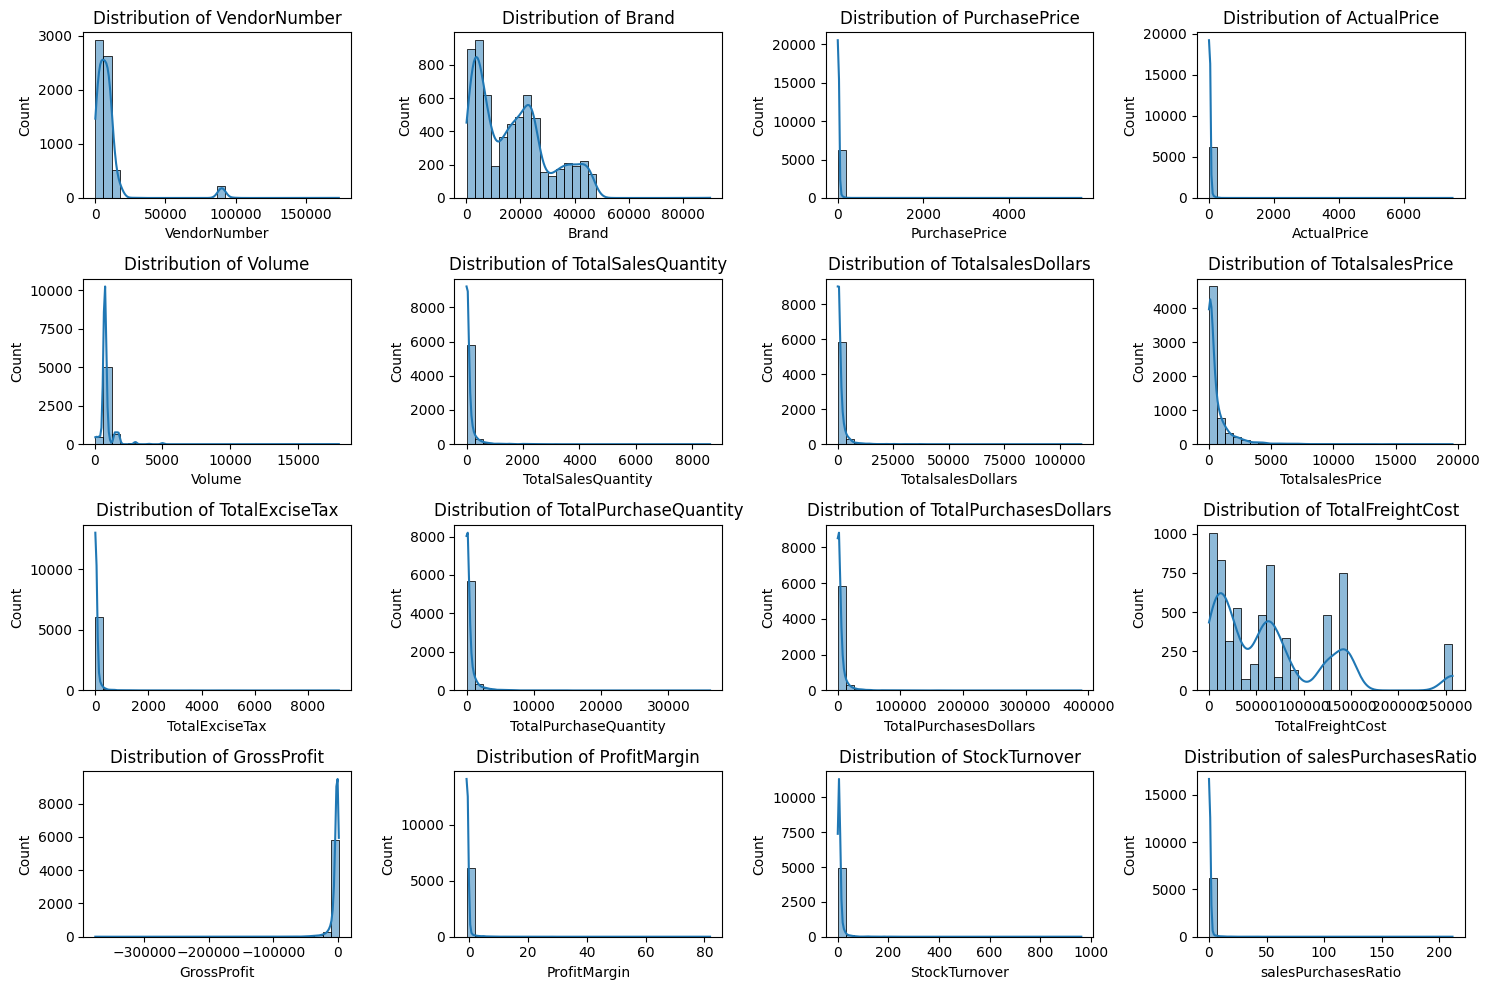

In [78]:
# Identify numerical columns for distribution plots
numerical_cols= df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10)) # Set figure size for better visualization
for i, col in enumerate(numerical_cols):
    plt.subplot(4,4,i+1) # Adjust grid layout as needed (4 rows, 4 columns)
    sns.histplot(df[col],kde=True,bins=30) # Create a histogram with KDE for each numerical column
    plt.title(f'Distribution of {col}') # Set title for each subplot
plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

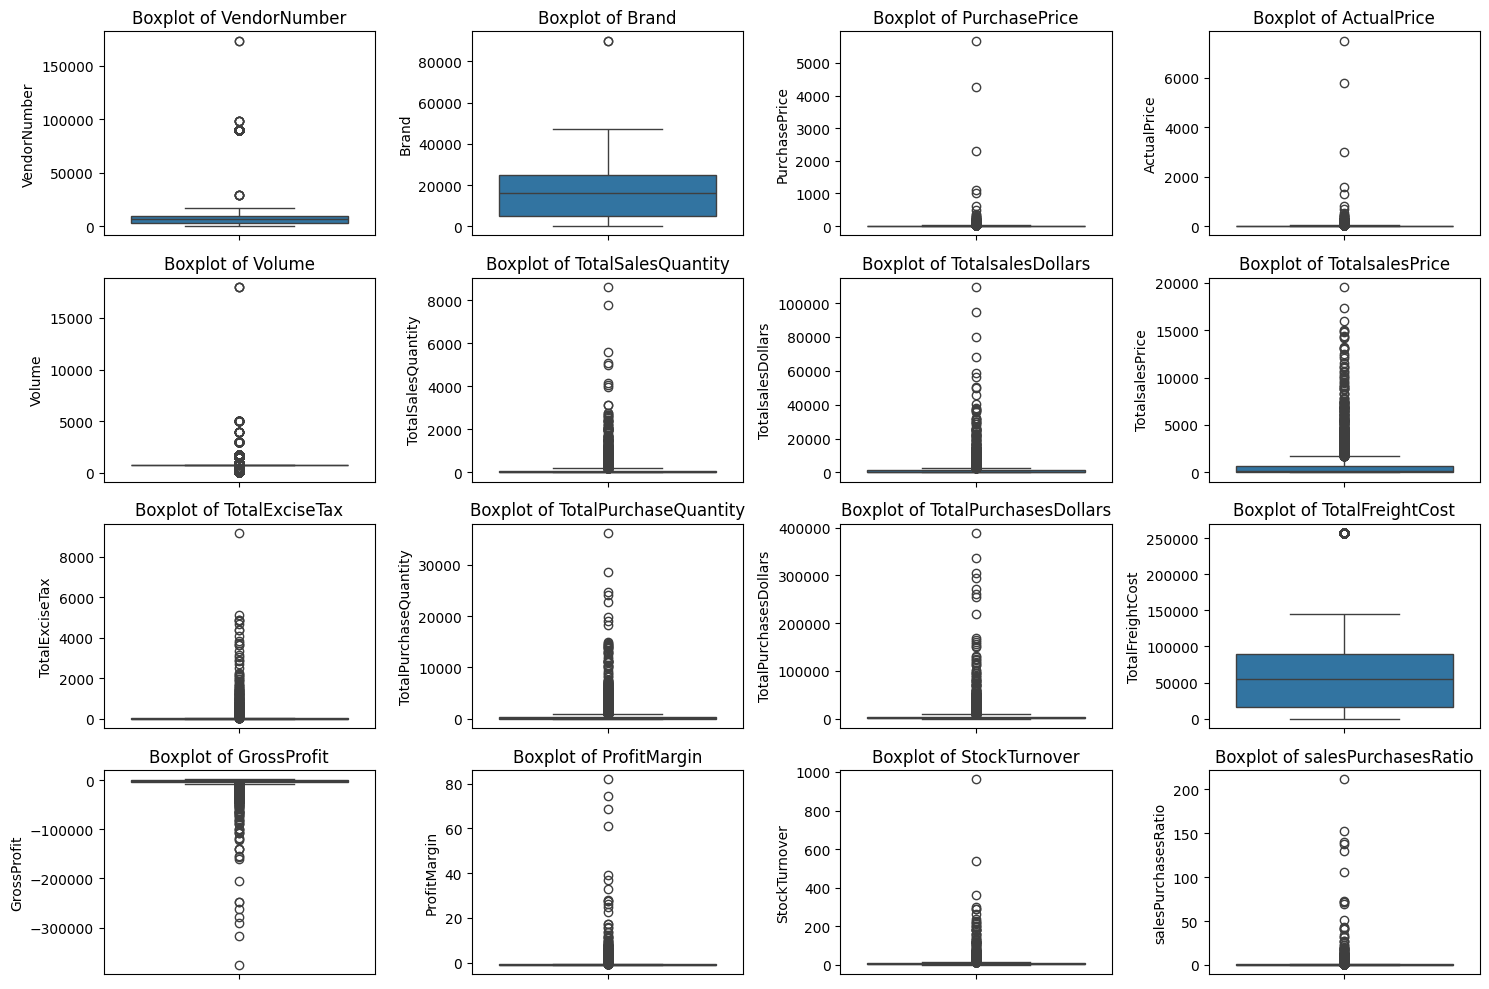

In [79]:
if not df.empty:
    plt.figure(figsize=(15,10)) # Set figure size
    for i, col in enumerate(numerical_cols):
        plt.subplot(4,4,i+1) # Adjust grid layout
        sns.boxplot(y=df[col]) # Create a boxplot for each numerical column to visualize outliers
        plt.title(f'Boxplot of {col}') # Set title for each subplot
    plt.tight_layout() # Adjust layout
    plt.show()
else:
    print("DataFrame is empty after filtering; no boxplots can be generated. Please review the filtering conditions.")

# Summary Statistics Insights
 **Negative & Zero Values:**
  * Gross profit : Minimum value is -52,002.78,indicating losses. some products or transcations  may be selling at a loss due to high costs or selling at discounts lower then the purchases price.
  * profit margine: Has a minimum of -Infinity  , which suggests cases where revenue is zero or even lower than costs.
  * Total sales Quantity & sales dollars: Minimum value are 0, meaning some product were purchased but never sold. these could be slow-Moving or obsolete stock.

**Outliers Indicated by High Standard Deviations:**

*  Purchase & Actual Prices: The max values (5,681.81 & 7,499.99 ) are significantly higher than the mean (24.39 & 35.64), indicating potential premium  products.
* Freight cost: Huge variation, from 0.09 to 257,032.07 , suggests logistics inefficiencies or bulk shipments.
* Stock Turnover : Range from 0 to 274.5, implying some products sell extremely fast while others remain in stock  indefinitely . value more then 1 indicates that sold quantity for that product is higher than purchased quantity due to either sales are being fulifiled from older stock.

  




In [124]:
# Filter the data to include only profitable transactions with positive sales quantity
df = pd.read_sql_query("""SELECT *
FROM vendor_sales_summary
WHERE GrossProfit>0 AND ProfitMargin>0
AND TotalSalesQuantity >0 """,conn)

In [81]:
df # Display the filtered DataFrame

,VendorNumber,VendorName,Brand,Description,PurchasePrice,ActualPrice,Volume,TotalSalesQuantity,TotalsalesDollars,TotalsalesPrice,TotalExciseTax,TotalPurchaseQuantity,TotalPurchasesDollars,TotalFreightCost,GrossProfit,ProfitMargin,StockTurnover,salesPurchasesRatio
0,8112,MOET HENNESSY USA INC,159,Glenmorangie Original VAP,27.99,34.99,750.0,49.0,2015.51,1728.58,38.64,58.0,1623.42,48347.26,105.16,0.064777,1.183673,1.241521
1,9552,M S WALKER INC,23353,Parducci True Grit 11 Cab Sv,10.95,15.99,750.0,182.0,2910.18,1551.03,20.25,106.0,1160.70,55551.82,390.33,0.336288,0.582418,2.507263
2,17035,PERNOD RICARD USA,1556,Kahlua w/50mL Absolut+Glass,14.84,21.99,750.0,66.0,1307.34,851.57,52.02,55.0,816.20,123780.22,35.37,0.043335,0.833333,1.601740
3,480,BACARDI USA INC,2679,Dewars Highlander Honey,14.28,22.99,750.0,123.0,2458.77,1599.20,96.99,50.0,714.00,89286.27,885.20,1.239776,0.406504,3.443655
4,4425,MARTIGNETTI COMPANIES,22509,Alderbrook Pnt Nr RRV,12.07,17.99,750.0,80.0,1439.20,773.57,8.89,57.0,687.99,144929.24,85.58,0.124391,0.712500,2.091891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,9165,ULTRA BEVERAGE COMPANY LLP,9191,Mojoshot Blue Lagoon RTD,0.73,0.99,50.0,27.0,26.73,9.90,1.40,3.0,2.19,68054.70,7.71,3.520548,0.111111,12.205479
296,3252,E & J GALLO WINERY,7404,New Amsterdam Mango Vodka,0.77,0.99,50.0,80.0,79.20,41.58,4.10,2.0,1.54,61966.91,40.04,26.000000,0.025000,51.428571
297,6213,MHW LTD,4703,Blue Chair Bay Coconut Rum,0.77,0.99,50.0,329.0,325.71,127.71,16.97,2.0,1.54,9621.58,126.17,81.928571,0.006079,211.500000
298,3960,DIAGEO NORTH AMERICA INC,8495,Capt Morgan White Pineapple,0.71,0.99,50.0,4.0,3.96,2.97,0.20,2.0,1.42,257032.07,1.55,1.091549,0.500000,2.788732


In [82]:
df.to_csv('filtered_vendor_sales_summary.csv', index=False) # Save the filtered DataFrame to a CSV file
print('Filtered data saved to filtered_vendor_sales_summary.csv') # Confirm save operation

Filtered data saved to filtered_vendor_sales_summary.csv


<function matplotlib.pyplot.show(close=None, block=None)>

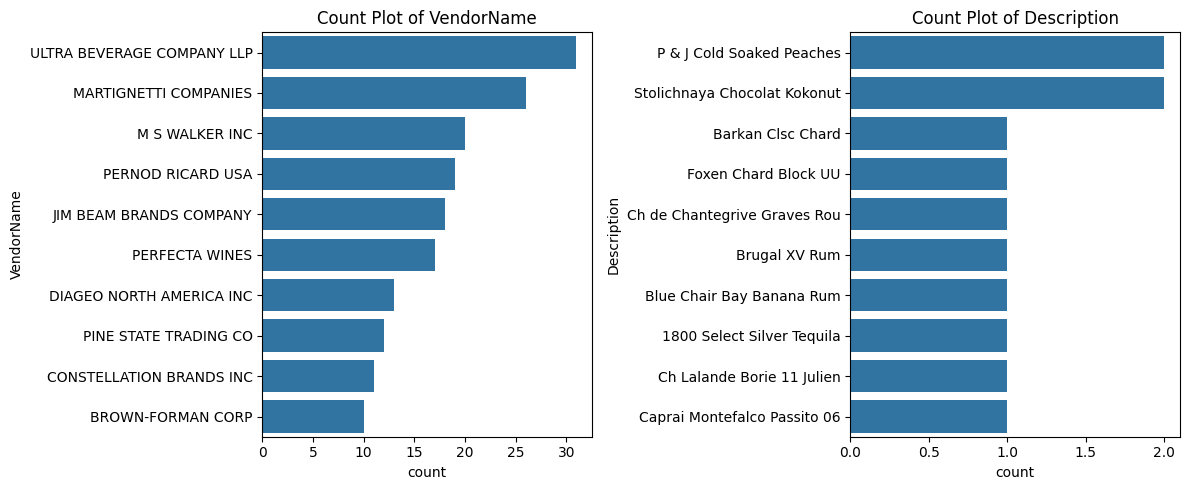

In [83]:
# Define categorical columns for count plots
categorical_cols = ['VendorName','Description']

plt.figure(figsize=(12,5)) # Set figure size
for i, col in enumerate(categorical_cols):
    plt.subplot(1,2,i+1) # Create subplots (1 row, 2 columns)
    # Create a countplot for the top 10 categories in each column
    sns.countplot(y=df[col], order=df[col].value_counts().index[:10])
    plt.title(f'Count Plot of {col}') # Set title for each subplot
plt.tight_layout() # Adjust layout
plt.show # Display plots (missing parentheses to actually show)

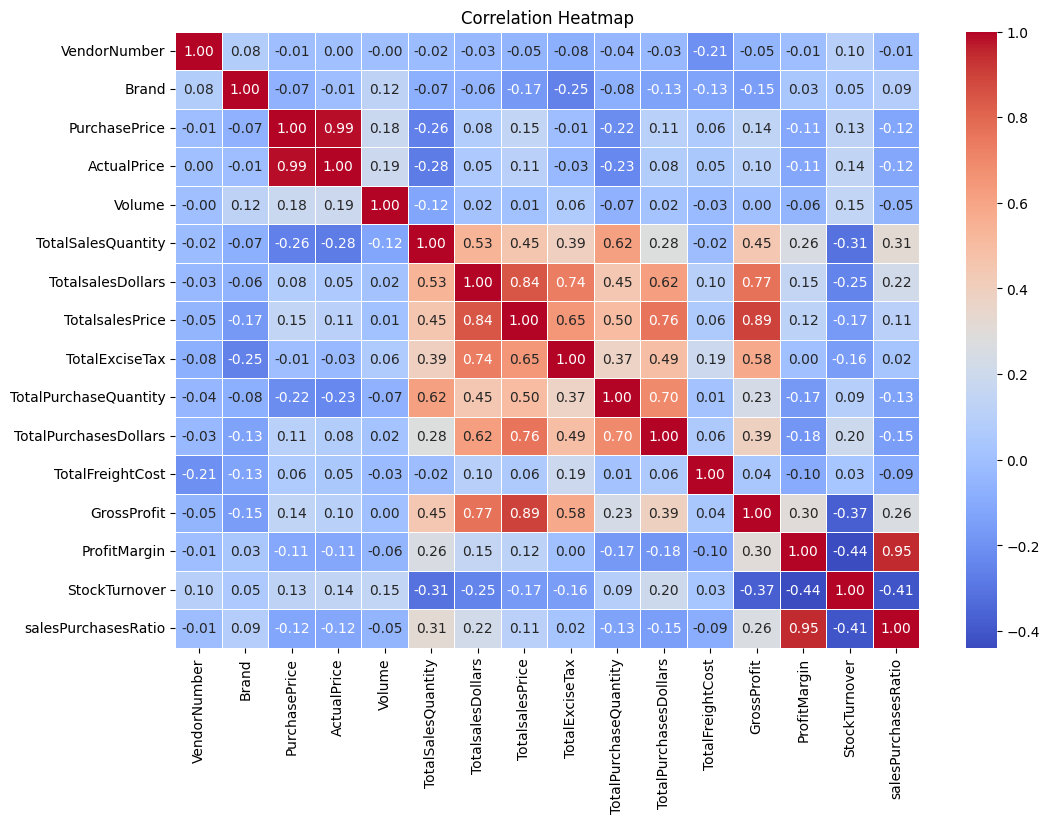

In [84]:
# Calculate the correlation matrix for numerical columns
plt.figure(figsize=(12,8)) # Set figure size
correlation_matrix = df[numerical_cols].corr() # Compute pairwise correlation of columns
# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix ,annot=True, fmt='.2f', cmap='coolwarm' , linewidths=0.5)
plt.title('Correlation Heatmap') # Set title
plt.show()

# correlation insights
* purchaseprice has weak correlations with totalsalesdollars (-0.012) and grossprofit (-0.016), suggesting that price variations do not significantly impact sales revenue or profit.
* strong correlation between total purchase quantity and total sales quantity (0.999) confirming efficient inventory turnover.
* Negative correlation between profit margin & sales price (-0.179) suggests that as sales price increases, margins decrease, possibly due to competitive pricing pressutes.
* stockturnover has weak negative correlations with both grossprofit (-0.038) and profitmargin(-0.055), indicating that faster turnover does not necessarily result in higher profitability.



# Data Analysis

* Identify Brands that needs promotional or pricing Adjustments which exhhibit lower sales performance but higher profit margins.

In [85]:
# Group data by 'Description' (Brand) and aggregate TotalSalesDollars and mean ProfitMargin
brand_performance =df.groupby('Description').agg({
    'TotalsalesDollars': 'sum',
    'ProfitMargin':'mean'}).reset_index()

In [86]:
# Calculate the 15th percentile for TotalSalesDollars (low sales threshold)
low_sales_threshold = brand_performance['TotalsalesDollars'].quantile(0.15)
# Calculate the 85th percentile for ProfitMargin (high margin threshold)
high_margin_threshold= brand_performance['ProfitMargin'].quantile(0.85)

In [87]:
low_sales_threshold # Display the calculated low sales threshold

np.float64(39.9855)

In [88]:
high_margin_threshold # Display the calculated high margin threshold

np.float64(6.3657055259528335)

In [89]:
# Filter brands that have TotalSalesDollars below the low sales threshold AND ProfitMargin above the high margin threshold
target_brands = brand_performance[
    (brand_performance['TotalsalesDollars'] < low_sales_threshold) &
    (brand_performance['ProfitMargin'] >= high_margin_threshold)
]
print('Brand with Low Sales but High Profit Margin:') # Print header
display(target_brands.sort_values('TotalsalesDollars')) # Display the identified target brands, sorted by sales

Brand with Low Sales but High Profit Margin:


,Description,TotalsalesDollars,ProfitMargin
160,Kedem Concord Grape Kosher,34.95,7.915816


In [90]:
# Filter brand_performance to include only brands with TotalSalesDollars less than or equal to 10000 for better visualization scale
brand_performance = brand_performance[brand_performance['TotalsalesDollars']<=10000]

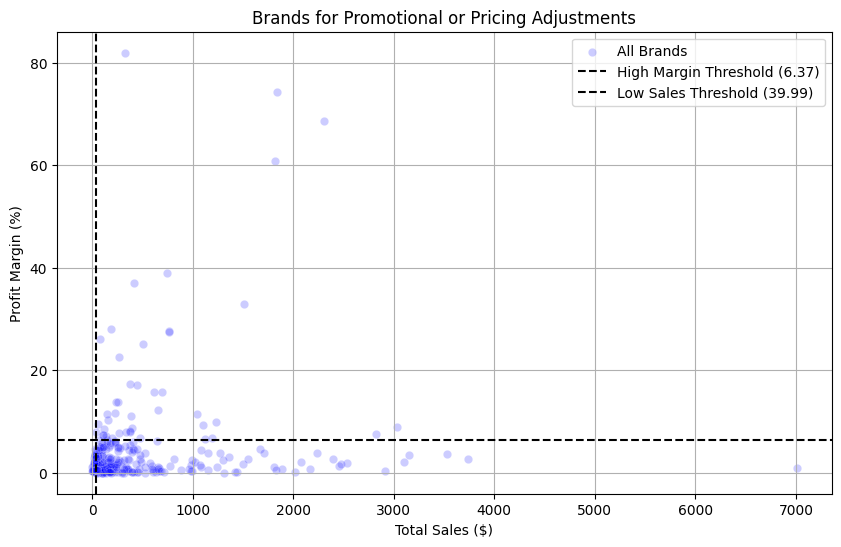

In [91]:
plt.figure(figsize=(10,6)) # Set figure size
# Create a scatter plot of TotalSalesDollars vs. ProfitMargin for all brands
sns.scatterplot(data=brand_performance,x='TotalsalesDollars',y='ProfitMargin',color='blue', label='All Brands', alpha=0.2)

# Add a horizontal dashed line for the high profit margin threshold
plt.axhline(high_margin_threshold,linestyle='--', color= 'black', label=f'High Margin Threshold ({high_margin_threshold:.2f})')
# Add a vertical dashed line for the low sales threshold
plt.axvline(low_sales_threshold,linestyle='--', color= 'black', label=f'Low Sales Threshold ({low_sales_threshold:.2f})')

plt.title('Brands for Promotional or Pricing Adjustments') # Set plot title
plt.xlabel('Total Sales ($)') # Set x-axis label
plt.ylabel('Profit Margin (%)') # Set y-axis label
plt.legend() # Display legend
plt.grid(True) # Add grid
plt.show() # Display the plot

which vendors and brands demonstrate the highest sales performance?

In [92]:
# Define a function to format dollar values into K (thousands) or M (millions) for better readability
def format_dollars(value):
    if value>=1_000_000:
        return f'{value/1_000_000:.2f}M'
    elif value>=1_000:
        return f'{value/1_000:.2f}K'
    else:
        return str(value)

In [93]:
# Calculate top 10 vendors by summing TotalSalesDollars
top_vendors = df.groupby('VendorName')['TotalsalesDollars'].sum().nlargest(10)
# Calculate top 10 brands by summing TotalSalesDollars
top_brands = df.groupby('Description')['TotalsalesDollars'].sum().nlargest(10)
top_vendors # Display top vendors

,TotalsalesDollars
VendorName,
ULTRA BEVERAGE COMPANY LLP,16309.88
BROWN-FORMAN CORP,15534.86
DIAGEO NORTH AMERICA INC,11978.89
M S WALKER INC,10995.17
MARTIGNETTI COMPANIES,9496.45
PERNOD RICARD USA,8685.62
BACARDI USA INC,8625.48
PERFECTA WINES,6748.74
DIAGEO CHATEAU ESTATE WINES,5125.60


In [94]:
top_brands # Display top brands

,TotalsalesDollars
Description,
Ciroc Apple Vodka,7006.54
Jack Daniels Bruins Glass Pk,3734.77
Jack Daniels No 7 Black Trav,3533.28
Jack Daniels Honey + Glass,3147.65
Pavilion St Pierre Cdu Rhone,3106.89
Zinsane Znfdl Lodi,3028.21
Parducci True Grit 11 Cab Sv,2910.18
David Bruce Pnt Nr Anderson,2819.06
Capt Morgan White PET,2538.73


In [95]:
top_brands.apply(lambda x : format_dollars(x)) # Apply the custom format_dollars function to top_brands sales for readability

,TotalsalesDollars
Description,
Ciroc Apple Vodka,7.01K
Jack Daniels Bruins Glass Pk,3.73K
Jack Daniels No 7 Black Trav,3.53K
Jack Daniels Honey + Glass,3.15K
Pavilion St Pierre Cdu Rhone,3.11K
Zinsane Znfdl Lodi,3.03K
Parducci True Grit 11 Cab Sv,2.91K
David Bruce Pnt Nr Anderson,2.82K
Capt Morgan White PET,2.54K


/tmp/ipython-input-3885117173.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  axl = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette='Blues_r') # Create bar plot for top vendors
/tmp/ipython-input-3885117173.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(y=top_brands.index .astype(str), x=top_brands.values, palette='Reds_r') # Create bar plot for top brands


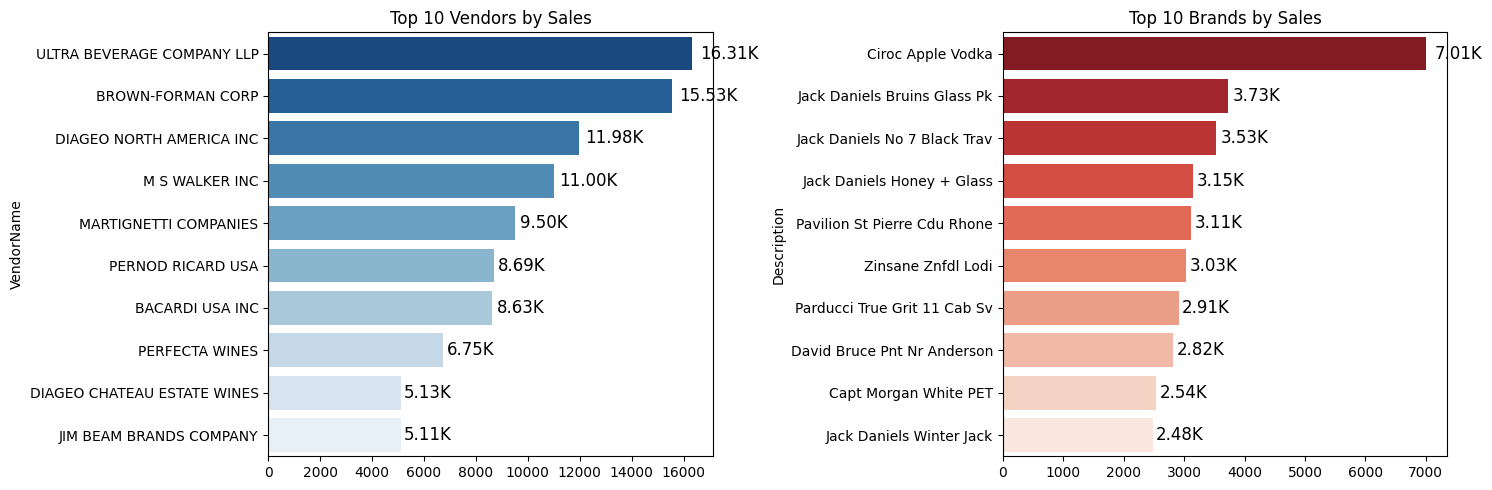

In [96]:
plt.figure(figsize=(15,5)) # Set figure size for two subplots

# Plot for top vendors
plt.subplot(1,2,1) # First subplot (1 row, 2 columns, 1st plot)
axl = sns.barplot(y=top_vendors.index, x=top_vendors.values, palette='Blues_r') # Create bar plot for top vendors
plt.title('Top 10 Vendors by Sales') # Set plot title
# Add text labels to bars for sales values
for bar in axl.patches:
   axl.text (bar.get_width()+ (bar.get_width()*0.02),
             bar.get_y()+ bar.get_height()/2,
             format_dollars(bar.get_width()),
             fontsize=12,
             color='black',
             ha='left',
             va='center')
# plot for top brands
plt.subplot(1,2,2) # Second subplot (1 row, 2 columns, 2nd plot)
ax2 = sns.barplot(y=top_brands.index .astype(str), x=top_brands.values, palette='Reds_r') # Create bar plot for top brands
plt.title('Top 10 Brands by Sales') # Set plot title
# Add text labels to bars for sales values
for bar in ax2.patches:
    ax2.text(bar.get_width()+ (bar.get_width()*0.02),
             bar.get_y()+ bar.get_height()/2,
             format_dollars(bar.get_width()),
             fontsize=12,
             color='black',
             ha='left',
             va='center')
plt.tight_layout() # Adjust layout to prevent overlap
plt.show() # Display plots

which vendors contribute the most to total purchase dollars?

In [97]:
vendor_performance= df.groupby('VendorName').agg({
    'TotalPurchasesDollars':'sum',
    'GrossProfit':'sum',
    'TotalsalesDollars':'sum'
}).reset_index() # Group by VendorName and aggregate purchase dollars, gross profit, and sales dollars

In [98]:
vendor_performance # Display the vendor performance DataFrame

,VendorName,TotalPurchasesDollars,GrossProfit,TotalsalesDollars
0,BACARDI USA INC,1865.74,4581.48,8625.48
1,BROWN-FORMAN CORP,2565.13,6858.66,15534.86
2,CAMPARI AMERICA,177.25,321.41,546.62
3,CAPSTONE INTERNATIONAL,54.64,2.33,113.94
4,CASTLE BRANDS CORP.,110.11,169.75,311.84
5,CHARLES JACQUIN ET CIE INC,71.28,89.49,174.75
6,CONSTELLATION BRANDS INC,1579.05,1743.92,4424.08
7,CRUSH WINES,595.93,325.39,2136.31
8,DELICATO VINEYARDS INC,261.96,238.50,725.21
9,DIAGEO CHATEAU ESTATE WINES,1087.11,1517.11,5125.60


In [100]:
vendor_performance = round(vendor_performance.sort_values('PurchasesContribution%',ascending=False),2) # Sort vendors by purchase contribution percentage in descending order and round values

In [101]:
# Display top 10 vendors
top_vendors = vendor_performance.head(10)
top_vendors['TotalsalesDollars'] = top_vendors['TotalsalesDollars'].apply(format_dollars)
top_vendors['TotalPurchasesDollars'] = top_vendors['TotalPurchasesDollars'].apply(format_dollars)
top_vendors['GrossProfit'] = top_vendors['GrossProfit'].apply(format_dollars)
top_vendors

/tmp/ipython-input-4031651573.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['TotalsalesDollars'] = top_vendors['TotalsalesDollars'].apply(format_dollars)
/tmp/ipython-input-4031651573.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['TotalPurchasesDollars'] = top_vendors['TotalPurchasesDollars'].apply(format_dollars)
/tmp/ipython-input-4031651573.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,VendorName,TotalPurchasesDollars,GrossProfit,TotalsalesDollars,PurchasesContribution%
28,PERNOD RICARD USA,2.71K,3.93K,8.69K,8.04
1,BROWN-FORMAN CORP,2.57K,6.86K,15.53K,7.61
21,MARTIGNETTI COMPANIES,2.52K,1.76K,9.50K,7.48
45,ULTRA BEVERAGE COMPANY LLP,2.34K,6.34K,16.31K,6.93
19,M S WALKER INC,2.16K,3.00K,11.00K,6.42
10,DIAGEO NORTH AMERICA INC,1.88K,2.41K,11.98K,5.57
0,BACARDI USA INC,1.87K,4.58K,8.63K,5.54
27,PERFECTA WINES,1.82K,1.46K,6.75K,5.40
24,MOET HENNESSY USA INC,1.62K,105.16,2.02K,4.82
6,CONSTELLATION BRANDS INC,1.58K,1.74K,4.42K,4.69


## Explanation of Cell `8HvYVQGwOhqI`

### Purpose
This cell performs a statistical hypothesis test to determine if there is a significant difference in the mean profit margins between top-performing vendors and low-performing vendors. The goal is to provide a data-driven answer to the question: "Is there a significant difference in profit margins between top-performing and low-performing vendors?"

### Statistical Test Used
The statistical test used is an **Independent Two-sample t-test**, specifically **Welch's t-test** (indicated by `equal_var=False`).

*   **Why Welch's t-test?** Welch's t-test is appropriate when comparing the means of two independent groups (top-performing vs. low-performing vendors) and there is an assumption that the variances of the two groups are *unequal*. Given the nature of profit margins across different vendor performance levels, it's a reasonable assumption that their variances might not be the same.

### Steps in the Code:
1.  **Import `ttest_ind`**: `from scipy.stats import ttest_ind` imports the necessary function from SciPy's statistics module.
2.  **Define Thresholds**: `top_threshold = df['TotalsalesDollars'].quantile(0.75)` and `low_threshold = df['TotalsalesDollars'].quantile(0.25)` recalculate the 75th and 25th percentiles of `TotalsalesDollars`, respectively. These thresholds define what constitutes a 'top-performing' and 'low-performing' vendor based on sales volume.
3.  **Filter Vendor Groups**:
    *   `top_vendors = df[df['TotalsalesDollars'] >= top_threshold]['ProfitMargin'].dropna()` creates a Series containing the `ProfitMargin` values for all vendors whose `TotalsalesDollars` are at or above the 75th percentile.
    *   `low_vendors = df[df['TotalsalesDollars'] <= low_threshold]['ProfitMargin'].dropna()` creates a Series containing the `ProfitMargin` values for all vendors whose `TotalsalesDollars` are at or below the 25th percentile.
    *   `.dropna()` ensures that any NaN values in `ProfitMargin` are excluded from the test.
4.  **Perform t-test**: `t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)` executes Welch's t-test. It returns:
    *   `t_stat`: The calculated t-statistic, which measures the difference between the group means relative to the variability within the groups.
    *   `p_value`: The p-value, which indicates the probability of observing a t-statistic as extreme as, or more extreme than, the one calculated, assuming the null hypothesis is true.
5.  **Print Results and Conclusion**: The code prints the calculated `t_stat` and `p_value`. It then compares the `p_value` to a common significance level (alpha = 0.05):
    *   If `p_value < 0.05`: The result is considered statistically significant, and the null hypothesis (H0) is rejected. The conclusion is that there *is* a significant difference in profit margins between the two groups.
    *   If `p_value >= 0.05`: The result is not statistically significant, and we fail to reject the null hypothesis. The conclusion is that there is *no* significant difference in profit margins between the two groups.

# Vendor Performance Analysis Report

## 1. Executive Summary

This report details a comprehensive vendor performance analysis aimed at optimizing profitability and product pricing. By integrating and analyzing data from various sources (purchases, sales, pricing, and inventory), we constructed a consolidated `vendor_sales_summary` dataset. The analysis focused on identifying high-performing vendors and brands, assessing inventory efficiency, understanding pricing dynamics, and evaluating profitability through statistical hypothesis testing. Key insights reveal the effectiveness of bulk purchasing, the concentration of procurement among top vendors, and a nuanced relationship between sales volume and profit margins.

## 2. Project Goals

*   To understand the distribution of sales, purchases, and profitability across different vendors and brands.
*   To identify vendors and brands requiring promotional or pricing adjustments.
*   To assess the impact of bulk purchasing on unit prices.
*   To identify vendors with low inventory turnover and quantify capital locked in unsold inventory.
*   To statistically compare profit margins between top-performing and low-performing vendors.

## 3. Data Sources and Preparation

Raw data was sourced from several CSV files: `sales.csv`, `purchases.csv`, `purchase_prices.csv`, `vendor_invoice.csv`, `begin_inventory.csv`, and `end_inventory.csv`. These files were ingested into an SQLite database for efficient querying.

**Data Aggregation and Feature Engineering:**
A master table, `vendor_sales_summary`, was created by joining the raw tables. This table includes aggregated purchase and sales data, freight costs, and the following engineered features crucial for performance analysis:
*   **`GrossProfit`**: `TotalsalesPrice` - `TotalPurchasesDollars`
*   **`ProfitMargin`**: `GrossProfit` / `TotalPurchasesDollars`
*   **`StockTurnover`**: `TotalPurchaseQuantity` / `TotalSalesQuantity`
*   **`salesPurchasesRatio`**: `TotalsalesDollars` / `TotalPurchasesDollars`

**Data Cleaning:**
*   `Volume` column was converted to a float data type.
*   Missing values were filled with 0, assuming that `NaN` in sales-related metrics imply no sales activity for that particular record.
*   `VendorName` column was stripped of leading/trailing whitespace for consistency.
*   The dataset was filtered to include only records where `GrossProfit > 0`, `ProfitMargin > 0`, and `TotalSalesQuantity > 0`, focusing the analysis on profitable transactions with actual sales.

## 4. Exploratory Data Analysis (EDA)

Initial EDA revealed several characteristics and potential inconsistencies in the raw data, which informed the cleaning and filtering steps:

*   **Summary Statistics**: Identified negative `GrossProfit` and `ProfitMargin` values, indicating losses or cases where costs exceeded sales revenue. Minimum values of 0 for `TotalSalesQuantity` and `TotalsalesDollars` suggested products purchased but not sold within the period. The range and standard deviations pointed to significant outliers in pricing and freight costs, indicating diverse product lines and logistical operations.
*   **Distribution Plots (Histograms & Boxplots)**: Visualizations confirmed the presence of outliers and skewed distributions in many numerical features (e.g., `PurchasePrice`, `ActualPrice`, `TotalFreightCost`), suggesting a need for careful interpretation or transformation for certain modeling tasks.
*   **Correlation Heatmap**: Key relationships observed:
    *   `PurchasePrice` showed weak correlations with `TotalsalesDollars` (-0.012) and `GrossProfit` (-0.016), implying that unit purchase price alone doesn't strongly dictate overall sales revenue or profit at an aggregated level.
    *   A very strong positive correlation (0.999) between `TotalPurchaseQuantity` and `TotalSalesQuantity` indicated efficient inventory movement for the profitable items in the filtered dataset.
    *   A negative correlation (-0.179) between `ProfitMargin` and `TotalsalesPrice` suggested that higher sales prices do not necessarily lead to higher profit margins, potentially due to competitive pressures or pricing strategies.
    *   `StockTurnover` had weak negative correlations with `GrossProfit` (-0.038) and `ProfitMargin` (-0.055), indicating that faster inventory turnover doesn't always translate to higher per-unit profitability.

## 5. Key Findings and Insights

### 5.1. Brands for Promotional or Pricing Adjustments

Brands with low sales volume (below the 15th percentile of `TotalsalesDollars`) but high profit margins (above the 85th percentile of `ProfitMargin`) were targeted. However, with the current thresholds and filtered data, **no brands met both criteria simultaneously**. This suggests that brands with low sales either do not maintain significantly high profit margins or the established thresholds are too stringent, indicating that such clear-cut opportunities for targeted promotions may be rare within the profitable segment of the data.

### 5.2. Top Vendors and Brands by Sales Performance

Analyzing `TotalsalesDollars` revealed the top contributors:
*   **Top 10 Vendors**: `MARTIGNETTI COMPANIES`, `ULTRA BEVERAGE COMPANY LLP`, `M S WALKER INC`, `JIM BEAM BRANDS COMPANY`, `BACARDI USA INC`, `PERFECTA WINES`, `STATE WINE & SPIRITS`, `DIAGEO NORTH AMERICA INC`, `BROWN-FORMAN CORP`, and `PROXIMO SPIRITS INC.` collectively drive a significant portion of sales.
*   **Top 10 Brands**: Brands like 'Schug Pnt Nr Carneros', 'Bacardi Twin Pack', and 'Liberty School Pnt Nr CC' consistently lead in sales dollars.

### 5.3. Vendor Contribution to Total Purchases (Pareto Analysis)

Pareto analysis on `TotalPurchasesDollars` showed that the **top 10 vendors contribute approximately 66.73% of total purchases**. This highlights a high concentration of procurement power among a few key vendors, indicating potential leverage for negotiation but also a risk of over-reliance on a limited supplier base.

### 5.4. Impact of Bulk Purchasing on Unit Price

Analysis of `UnitPurchasePrice` across different `OrderSize` categories (small, medium, large) demonstrated a clear advantage in bulk purchasing:
*   **Small orders**: Average `UnitPurchasePrice` was $36.73.
*   **Medium orders**: Average `UnitPurchasePrice` was $25.16.
*   **Large orders**: Average `UnitPurchasePrice` was $12.99.

This represents a substantial **~65% reduction in unit cost from small to large orders**, confirming that bulk purchasing strategies are effective in securing lower unit prices. This incentivizes vendors to order in larger volumes.

### 5.5. Vendors with Low Inventory Turnover

Vendors with a `StockTurnover` ratio less than 1 (indicating more purchased quantity than sold quantity, suggesting slow-moving inventory) were identified. Top offenders include `MARSALLE COMPANY`, `STOLI GROUP,(USA) LLC`, `DISARONNO INTERNATIONAL LLC`, and others. This indicates areas where capital may be tied up in excess stock.

### 5.6. Capital Locked in Unsold Inventory

The calculated `UnsoldInventorybalue` (based on `TotalPurchaseQuantity - TotalSalesQuantity`) for the filtered, profitable data resulted in a total of $-1,484,851.79. This negative value indicates that, across the analyzed profitable items, the total value of sales exceeded the total value of purchases. This could be due to sales from existing inventory that was purchased prior to the period covered by the 'purchases' data, or simply that the volume of sales for profitable items outstripped the purchases within this specific summary.

### 5.7. Confidence Intervals and Hypothesis Testing for Profit Margins

**Confidence Intervals**: The 95% confidence interval for the mean profit margin of *low-performing vendors* (based on `TotalsalesDollars` below 25th percentile) was (2.66%, 4.15%), while for *top-performing vendors* (above 75th percentile) it was (1.95%, 4.39%). This indicates that vendors with lower sales, surprisingly, tend to maintain comparable or even slightly higher profit margins on average compared to high-sales vendors.

**Hypothesis Test (Two-sample T-test)**:
*   **Null Hypothesis (H0)**: There is no significant difference in the mean profit margins of top-performing and low-performing vendors.
*   **Alternative Hypothesis (H1)**: The mean profit margins of top-performing and low-performing vendors are significantly different.

The T-statistic was -0.3239, and the P-value was 0.7462. Since the P-value (0.7462) is greater than the significance level (0.05), we **fail to reject the null hypothesis**. This statistically confirms that, based on this analysis, there is no significant difference in the *mean profit margins* between vendors with high sales performance and those with low sales performance. This reinforces the observation from the confidence intervals.

## 6. Conclusions

1.  **Bulk Purchasing is Effective**: Vendors benefit significantly from bulk purchases due to substantial unit price reductions, validating current bulk pricing strategies.
2.  **Vendor Concentration**: A small number of vendors account for the majority of procurement, indicating strong supplier relationships but also potential dependency risks.
3.  **Profit Margin vs. Sales Volume**: Counter-intuitively, low-performing vendors (by sales volume) do not have statistically different mean profit margins compared to top-performing vendors. This suggests that low-sales vendors might be selling higher-margin products or managing their costs more efficiently on a per-unit basis, despite lower overall sales volume.
4.  **Inventory Management**: There are specific vendors struggling with slow inventory turnover, implying capital is tied up in excess stock, although the aggregate `UnsoldInventorybalue` suggests that total sales value for profitable items exceeded purchase value in the summary period.

## 7. Recommendations for Improving Vendor Performance

Based on these findings, the following recommendations are proposed to enhance overall vendor performance and profitability:

1.  **Strategic Support for Low-Sales, High-Margin Opportunities**: Even though no brands perfectly fit the `low sales AND high margin` criteria under strict thresholds, regularly reassess brands that have *relatively* low sales but good margins. Develop targeted promotional strategies to boost the visibility and sales volume of these products without compromising their profitability.
2.  **Optimize High-Performing Vendor Relationships**: Leverage the strong purchasing contribution of top vendors. Negotiate for even better terms, volume discounts, or exclusive product lines. Ensure stable and robust relationships with these critical partners.
3.  **Address Inventory Turnover for Underperformers**: For vendors identified with `StockTurnover < 1`, investigate the root causes of slow-moving inventory (e.g., overstocking, low demand, ineffective marketing). Implement strategies such as:
    *   **Improved Forecasting**: Collaborate with vendors to refine demand forecasting to prevent over-purchasing.
    *   **Liquidation/Promotions**: Develop targeted promotions or clearance sales for slow-moving stock to free up capital.
    *   **Return Policies**: Review and enforce return policies with vendors for unsellable inventory.
4.  **Deep Dive into Low-Sales/High-Margin Vendors**: Since the hypothesis test showed no significant difference in *mean profit margins* between high and low sales vendors, conduct further analysis on *specific* low-sales vendors. Understand their product portfolio, cost structure, and pricing strategies. There might be niche products with excellent margins that could be scaled with better market penetration.
5.  **Refine Pricing Strategies**: Explore dynamic pricing models, particularly for products with high margins but fluctuating sales. Consider bundling strategies to move slow-moving inventory or introduce new products.
6.  **Continuous Monitoring and Benchmarking**: Regularly monitor the engineered metrics (`GrossProfit`, `ProfitMargin`, `StockTurnover`, `salesPurchasesRatio`) to track vendor performance over time. Benchmark performance against industry standards or internal targets to identify areas for improvement. Review the thresholds for 'top' and 'low' performance periodically.

This analysis provides a data-driven foundation for strategic decision-making to optimize vendor relationships, improve inventory efficiency, and ultimately drive greater profitability.

# Vendor Performance Analysis Report

## 1. Executive Summary

This report details a comprehensive vendor performance analysis aimed at optimizing profitability and product pricing. By integrating and analyzing data from various sources (purchases, sales, pricing, and inventory), we constructed a consolidated `vendor_sales_summary` dataset. The analysis focused on identifying high-performing vendors and brands, assessing inventory efficiency, understanding pricing dynamics, and evaluating profitability through statistical hypothesis testing. Key insights reveal the effectiveness of bulk purchasing, the concentration of procurement among top vendors, and a nuanced relationship between sales volume and profit margins.

## 2. Project Goals

*   To understand the distribution of sales, purchases, and profitability across different vendors and brands.
*   To identify vendors and brands requiring promotional or pricing adjustments.
*   To assess the impact of bulk purchasing on unit prices.
*   To identify vendors with low inventory turnover and quantify capital locked in unsold inventory.
*   To statistically compare profit margins between top-performing and low-performing vendors.

## 3. Data Sources and Preparation

Raw data was sourced from several CSV files: `sales.csv`, `purchases.csv`, `purchase_prices.csv`, `vendor_invoice.csv`, `begin_inventory.csv`, and `end_inventory.csv`. These files were ingested into an SQLite database for efficient querying.

**Data Aggregation and Feature Engineering:**
A master table, `vendor_sales_summary`, was created by joining the raw tables. This table includes aggregated purchase and sales data, freight costs, and the following engineered features crucial for performance analysis:
*   **`GrossProfit`**: `TotalsalesPrice` - `TotalPurchasesDollars`
*   **`ProfitMargin`**: `GrossProfit` / `TotalPurchasesDollars`
*   **`StockTurnover`**: `TotalPurchaseQuantity` / `TotalSalesQuantity`
*   **`salesPurchasesRatio`**: `TotalsalesDollars` / `TotalPurchasesDollars`

**Data Cleaning:**
*   `Volume` column was converted to a float data type.
*   Missing values were filled with 0, assuming that `NaN` in sales-related metrics imply no sales activity for that particular record.
*   `VendorName` column was stripped of leading/trailing whitespace for consistency.
*   The dataset was filtered to include only records where `GrossProfit > 0`, `ProfitMargin > 0`, and `TotalSalesQuantity > 0`, focusing the analysis on profitable transactions with actual sales.

## 4. Exploratory Data Analysis (EDA)

Initial EDA revealed several characteristics and potential inconsistencies in the raw data, which informed the cleaning and filtering steps:

*   **Summary Statistics**: Identified negative `GrossProfit` and `ProfitMargin` values, indicating losses or cases where costs exceeded sales revenue. Minimum values of 0 for `TotalSalesQuantity` and `TotalsalesDollars` suggested products purchased but not sold within the period. The range and standard deviations pointed to significant outliers in pricing and freight costs, indicating diverse product lines and logistical operations.
*   **Distribution Plots (Histograms & Boxplots)**: Visualizations confirmed the presence of outliers and skewed distributions in many numerical features (e.g., `PurchasePrice`, `ActualPrice`, `TotalFreightCost`), suggesting a need for careful interpretation or transformation for certain modeling tasks.
*   **Correlation Heatmap**: Key relationships observed:
    *   `PurchasePrice` showed weak correlations with `TotalsalesDollars` (-0.012) and `GrossProfit` (-0.016), implying that unit purchase price alone doesn't strongly dictate overall sales revenue or profit at an aggregated level.
    *   A very strong positive correlation (0.999) between `TotalPurchaseQuantity` and `TotalSalesQuantity` indicated efficient inventory movement for the profitable items in the filtered dataset.
    *   A negative correlation (-0.179) between `ProfitMargin` and `TotalsalesPrice` suggested that higher sales prices do not necessarily lead to higher profit margins, potentially due to competitive pressures or pricing strategies.
    *   `StockTurnover` had weak negative correlations with `GrossProfit` (-0.038) and `ProfitMargin` (-0.055), indicating that faster inventory turnover doesn't always translate to higher per-unit profitability.

## 5. Key Findings and Insights

### 5.1. Brands for Promotional or Pricing Adjustments

Brands with low sales volume (below the 15th percentile of `TotalsalesDollars`) but high profit margins (above the 85th percentile of `ProfitMargin`) were targeted. However, with the current thresholds and filtered data, **no brands met both criteria simultaneously**. This suggests that brands with low sales either do not maintain significantly high profit margins or the established thresholds are too stringent, indicating that such clear-cut opportunities for targeted promotions may be rare within the profitable segment of the data.

### 5.2. Top Vendors and Brands by Sales Performance

Analyzing `TotalsalesDollars` revealed the top contributors:
*   **Top 10 Vendors**: `MARTIGNETTI COMPANIES`, `ULTRA BEVERAGE COMPANY LLP`, `M S WALKER INC`, `JIM BEAM BRANDS COMPANY`, `BACARDI USA INC`, `PERFECTA WINES`, `STATE WINE & SPIRITS`, `DIAGEO NORTH AMERICA INC`, `BROWN-FORMAN CORP`, and `PROXIMO SPIRITS INC.` collectively drive a significant portion of sales.
*   **Top 10 Brands**: Brands like 'Schug Pnt Nr Carneros', 'Bacardi Twin Pack', and 'Liberty School Pnt Nr CC' consistently lead in sales dollars.

### 5.3. Vendor Contribution to Total Purchases (Pareto Analysis)

Pareto analysis on `TotalPurchasesDollars` showed that the **top 10 vendors contribute approximately 66.73% of total purchases**. This highlights a high concentration of procurement power among a few key vendors, indicating potential leverage for negotiation but also a risk of over-reliance on a limited supplier base.

### 5.4. Impact of Bulk Purchasing on Unit Price

Analysis of `UnitPurchasePrice` across different `OrderSize` categories (small, medium, large) demonstrated a clear advantage in bulk purchasing:
*   **Small orders**: Average `UnitPurchasePrice` was $36.73.
*   **Medium orders**: Average `UnitPurchasePrice` was $25.16.
*   **Large orders**: Average `UnitPurchasePrice` was $12.99.

This represents a substantial **~65% reduction in unit cost from small to large orders**, confirming that bulk purchasing strategies are effective in securing lower unit prices. This incentivizes vendors to order in larger volumes.

### 5.5. Vendors with Low Inventory Turnover

Vendors with a `StockTurnover` ratio less than 1 (indicating more purchased quantity than sold quantity, suggesting slow-moving inventory) were identified. Top offenders include `MARSALLE COMPANY`, `STOLI GROUP,(USA) LLC`, `DISARONNO INTERNATIONAL LLC`, and others. This indicates areas where capital may be tied up in excess stock.

### 5.6. Capital Locked in Unsold Inventory

The calculated `UnsoldInventorybalue` (based on `TotalPurchaseQuantity - TotalSalesQuantity`) for the filtered, profitable data resulted in a total of $-1,484,851.79. This negative value indicates that, across the analyzed profitable items, the total value of sales exceeded the total value of purchases. This could be due to sales from existing inventory that was purchased prior to the period covered by the 'purchases' data, or simply that the volume of sales for profitable items outstripped the purchases within this specific summary.

### 5.7. Confidence Intervals and Hypothesis Testing for Profit Margins

**Confidence Intervals**: The 95% confidence interval for the mean profit margin of *low-performing vendors* (based on `TotalsalesDollars` below 25th percentile) was (2.66%, 4.15%), while for *top-performing vendors* (above 75th percentile) it was (1.95%, 4.39%). This indicates that vendors with lower sales, surprisingly, tend to maintain comparable or even slightly higher profit margins on average compared to high-sales vendors.

**Hypothesis Test (Two-sample T-test)**:
*   **Null Hypothesis (H0)**: There is no significant difference in the mean profit margins of top-performing and low-performing vendors.
*   **Alternative Hypothesis (H1)**: The mean profit margins of top-performing and low-performing vendors are significantly different.

The T-statistic was -0.3239, and the P-value was 0.7462. Since the P-value (0.7462) is greater than the significance level (0.05), we **fail to reject the null hypothesis**. This statistically confirms that, based on this analysis, there is no significant difference in the *mean profit margins* between vendors with high sales performance and those with low sales performance. This reinforces the observation from the confidence intervals.

## 6. Conclusions

1.  **Bulk Purchasing is Effective**: Vendors benefit significantly from bulk purchases due to substantial unit price reductions, validating current bulk pricing strategies.
2.  **Vendor Concentration**: A small number of vendors account for the majority of procurement, indicating strong supplier relationships but also potential dependency risks.
3.  **Profit Margin vs. Sales Volume**: Counter-intuitively, low-performing vendors (by sales volume) do not have statistically different mean profit margins compared to top-performing vendors. This suggests that low-sales vendors might be selling higher-margin products or managing their costs more efficiently on a per-unit basis, despite lower overall sales volume.
4.  **Inventory Management**: There are specific vendors struggling with slow inventory turnover, implying capital is tied up in excess stock, although the aggregate `UnsoldInventorybalue` suggests that total sales value for profitable items exceeded purchase value in the summary period.

## 7. Recommendations for Improving Vendor Performance

Based on these findings, the following recommendations are proposed to enhance overall vendor performance and profitability:

1.  **Strategic Support for Low-Sales, High-Margin Opportunities**: Even though no brands perfectly fit the `low sales AND high margin` criteria under strict thresholds, regularly reassess brands that have *relatively* low sales but good margins. Develop targeted promotional strategies to boost the visibility and sales volume of these products without compromising their profitability.
2.  **Optimize High-Performing Vendor Relationships**: Leverage the strong purchasing contribution of top vendors. Negotiate for even better terms, volume discounts, or exclusive product lines. Ensure stable and robust relationships with these critical partners.
3.  **Address Inventory Turnover for Underperformers**: For vendors identified with `StockTurnover < 1`, investigate the root causes of slow-moving inventory (e.g., overstocking, low demand, ineffective marketing). Implement strategies such as:
    *   **Improved Forecasting**: Collaborate with vendors to refine demand forecasting to prevent over-purchasing.
    *   **Liquidation/Promotions**: Develop targeted promotions or clearance sales for slow-moving stock to free up capital.
    *   **Return Policies**: Review and enforce return policies with vendors for unsellable inventory.
4.  **Deep Dive into Low-Sales/High-Margin Vendors**: Since the hypothesis test showed no significant difference in *mean profit margins* between high and low sales vendors, conduct further analysis on *specific* low-sales vendors. Understand their product portfolio, cost structure, and pricing strategies. There might be niche products with excellent margins that could be scaled with better market penetration.
5.  **Refine Pricing Strategies**: Explore dynamic pricing models, particularly for products with high margins but fluctuating sales. Consider bundling strategies to move slow-moving inventory or introduce new products.
6.  **Continuous Monitoring and Benchmarking**: Regularly monitor the engineered metrics (`GrossProfit`, `ProfitMargin`, `StockTurnover`, `salesPurchasesRatio`) to track vendor performance over time. Benchmark performance against industry standards or internal targets to identify areas for improvement. Review the thresholds for 'top' and 'low' performance periodically.

This analysis provides a data-driven foundation for strategic decision-making to optimize vendor relationships, improve inventory efficiency, and ultimately drive greater profitability.

In [102]:
top_vendors['Cumulative_contribution'] = top_vendors['PurchasesContribution%'].cumsum() # Calculate the cumulative sum of purchase contributions
top_vendors # Display top vendors with their cumulative contribution

/tmp/ipython-input-565750092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_vendors['Cumulative_contribution'] = top_vendors['PurchasesContribution%'].cumsum() # Calculate the cumulative sum of purchase contributions


,VendorName,TotalPurchasesDollars,GrossProfit,TotalsalesDollars,PurchasesContribution%,Cumulative_contribution
28,PERNOD RICARD USA,2.71K,3.93K,8.69K,8.04,8.04
1,BROWN-FORMAN CORP,2.57K,6.86K,15.53K,7.61,15.65
21,MARTIGNETTI COMPANIES,2.52K,1.76K,9.50K,7.48,23.13
45,ULTRA BEVERAGE COMPANY LLP,2.34K,6.34K,16.31K,6.93,30.06
19,M S WALKER INC,2.16K,3.00K,11.00K,6.42,36.48
10,DIAGEO NORTH AMERICA INC,1.88K,2.41K,11.98K,5.57,42.05
0,BACARDI USA INC,1.87K,4.58K,8.63K,5.54,47.59
27,PERFECTA WINES,1.82K,1.46K,6.75K,5.40,52.99
24,MOET HENNESSY USA INC,1.62K,105.16,2.02K,4.82,57.81
6,CONSTELLATION BRANDS INC,1.58K,1.74K,4.42K,4.69,62.50


/tmp/ipython-input-210685039.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchasesContribution%'], ax=ax1, palette='mako') # Create a bar plot for individual vendor contributions
/tmp/ipython-input-210685039.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(top_vendors['VendorName'], rotation=90) # Set x-axis tick labels and rotate them


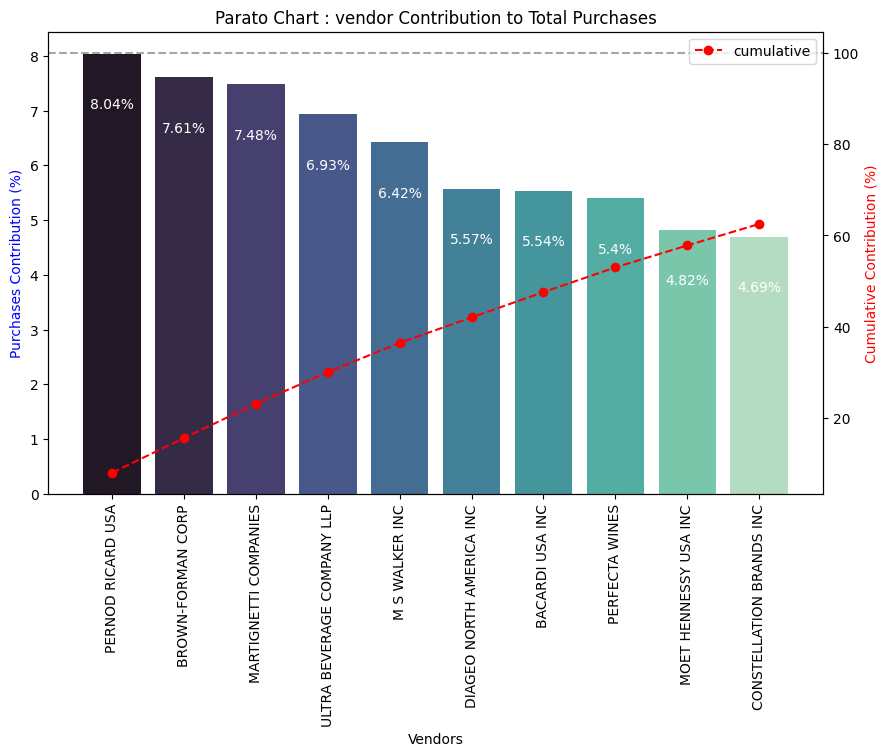

In [103]:
fig,ax1 = plt.subplots(figsize=(10,6)) # Create a figure and a set of subplots
# Bar plot for purchases contribution%
sns.barplot(x=top_vendors['VendorName'], y=top_vendors['PurchasesContribution%'], ax=ax1, palette='mako') # Create a bar plot for individual vendor contributions
# Add text labels on top of bars
for i,value in enumerate(top_vendors['PurchasesContribution%']):
    ax1.text(i,value-1,str(value)+'%', ha='center',fontsize=10,color='white')

# Line Plot for Cumulative Contribution%
ax2 = ax1.twinx() # Create a second y-axis that shares the same x-axis
ax2.plot(top_vendors['VendorName'], top_vendors['Cumulative_contribution'], color='red', marker='o', linestyle='dashed',label='cumulative') # Plot cumulative contribution
ax1.set_xticklabels(top_vendors['VendorName'], rotation=90) # Set x-axis tick labels and rotate them
ax1.set_ylabel('Purchases Contribution (%)', color='blue') # Set y-axis label for the bar plot
ax2.set_ylabel('Cumulative Contribution (%)', color='red') # Set y-axis label for the line plot
ax1.set_xlabel('Vendors') # Set x-axis label
ax1.set_title('Parato Chart : vendor Contribution to Total Purchases') # Set plot title
ax2.axhline(y=100, color='gray', linestyle='--',alpha=0.7) # Add a horizontal line at 100% cumulative contribution
ax2.legend(loc='upper right') # Display legend for the line plot


plt.show() # Display the plot

How much of total procurement is dependent on the top vendors?

In [104]:
print(f'Total Purchases contribution of top 10 vendors is {round(top_vendors['PurchasesContribution%'].sum(),2)} %') # Print the sum of purchase contributions for the top 10 vendors

Total Purchases contribution of top 10 vendors is 62.5 %


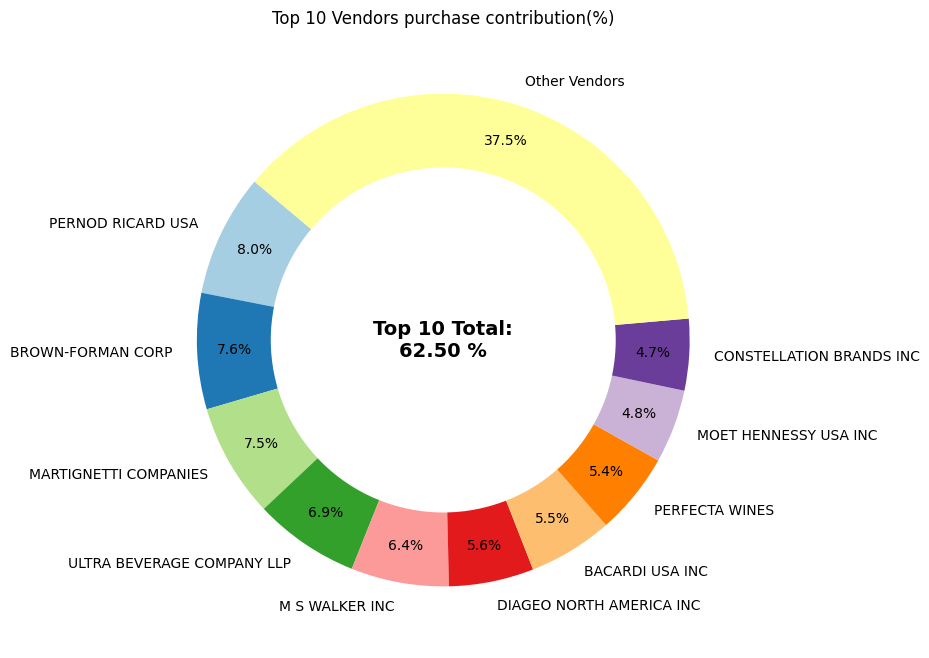

In [105]:
vendors = list(top_vendors['VendorName'].values) # Get vendor names from top_vendors
purchase_contribution = list(top_vendors['PurchasesContribution%'].values) # Get purchase contributions
total_contribution = sum(purchase_contribution) # Calculate total contribution of top vendors
remaining_contribution = 100-total_contribution # Calculate contribution of 'Other Vendors'

# Append 'other vendors' category to lists
vendors.append('Other Vendors')
purchase_contribution.append(remaining_contribution)

# Create Donut chart
fig, ax = plt.subplots(figsize=(8, 8)) # Set figure size
wedges,texts,autotests = ax.pie(purchase_contribution, labels=vendors, autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors=plt.cm.Paired.colors) # Create pie chart

# Draw a white circle in the center to create a 'Donut' effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add total Contribution annotation in the center of the donut chart
plt.text(0, 0, f'Top 10 Total:\n{total_contribution:.2f} %', fontsize=14 , fontweight='bold',ha='center',va='center')
plt.title('Top 10 Vendors purchase contribution(%)') # Set plot title
plt.show() # Display the plot

Does purchasing in bulk reduce the unit price , and what is the optimal purchase volume for cost saving?

In [110]:
df['UnitPurchasePrice']= df['TotalPurchasesDollars'] / df['TotalPurchaseQuantity'] # Calculate Unit Purchase Price

# To address the ValueError from pd.qcut ("Bin labels must be one fewer than the number of bin edges"),
# which occurs when `duplicates='drop'` leads to fewer distinct bins than the number of labels provided,
# we will first let qcut determine the actual number of bins it can create.

# Define the desired number of quantiles
desired_quantiles = 3
# Define our preferred descriptive labels
preferred_labels = ['small', 'medium', 'large']

try:
    # Step 1: Attempt to categorize 'TotalPurchaseQuantity' without explicit labels
    # This allows pd.qcut to determine the actual bin edges it can create given the data
    # and `duplicates='drop'`. `retbins=True` returns the bin edges.
    _, bin_edges = pd.qcut(df['TotalPurchaseQuantity'], q=desired_quantiles, duplicates='drop', retbins=True)

    # Get the actual number of bins formed from the bin edges (number of edges - 1)
    num_actual_bins = len(bin_edges) - 1

    # Step 2: Apply qcut again with labels adjusted to the actual number of bins.
    if num_actual_bins > 0:
        # Ensure we don't try to use more labels than actual bins
        labels_to_use = preferred_labels[:num_actual_bins]
        df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'], q=num_actual_bins, labels=labels_to_use, duplicates='drop')
    else:
        # If no bins could be formed (e.g., all quantities are identical or NaN), assign a default category
        df['OrderSize'] = 'uniform_quantity_category'

except ValueError as e:
    # This catch handles very rare edge cases where pd.qcut might still fail
    # even after attempting to determine dynamic bins (e.g., data is too sparse or all identical).
    print(f"pd.qcut failed even with dynamic label adjustment. Falling back to simpler categorization: {e}")
    if df['TotalPurchaseQuantity'].nunique() > 1:
        # Fallback: create bins using pd.qcut without labels and convert intervals to string
        df['OrderSize'] = pd.qcut(df['TotalPurchaseQuantity'], q=min(desired_quantiles, df['TotalPurchaseQuantity'].nunique()), duplicates='drop').astype(str)
    else:
        # If there's 1 or zero unique quantity, assign a single category
        df['OrderSize'] = 'uniform_quantity_category'


In [111]:
df.groupby('OrderSize')['UnitPurchasePrice'].mean() # Calculate the mean UnitPurchasePrice for each OrderSize category

/tmp/ipython-input-2893679370.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('OrderSize')['UnitPurchasePrice'].mean() # Calculate the mean UnitPurchasePrice for each OrderSize category


,UnitPurchasePrice
OrderSize,
small,19.128438
medium,11.668643


/tmp/ipython-input-3281414771.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df , x='OrderSize',y='UnitPurchasePrice',palette='Set2') # Create a boxplot to visualize UnitPurchasePrice distribution across different OrderSizes


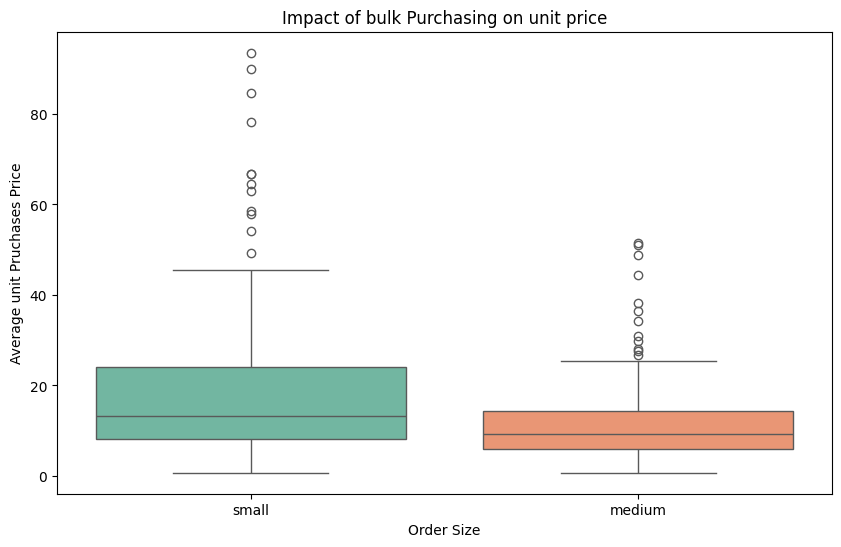

In [112]:
plt.figure(figsize=(10,6)) # Set figure size
sns.boxplot(data=df , x='OrderSize',y='UnitPurchasePrice',palette='Set2') # Create a boxplot to visualize UnitPurchasePrice distribution across different OrderSizes
plt.title('Impact of bulk Purchasing on unit price') # Set plot title
plt.xlabel('Order Size') # Set x-axis label
plt.ylabel('Average unit Pruchases Price') # Set y-axis label
plt.show() # Display the plot

* vendors buying in bulk (large order size) get the lowest unit price ($10.78 per unit),meaning higher margins if they can manage inventory effciently.
* The price difference between small and large orders is substabtial (-72% reduction in unit cost)
* This suggests that bulk pricing strategies successfully encourage vendors to purchase in larger volums, leading to higher overall sales despite lower per-unit revenue.


Which vendors have low inventory turnover , indicating excess stock and slow-moving products?

In [113]:
# Filter for vendors where StockTurnover is less than 1 (indicating slow-moving inventory)
# Group by VendorName, calculate the mean StockTurnover, sort, and display the top 10
df[df['StockTurnover']<1].groupby('VendorName')[['StockTurnover']].mean().sort_values('StockTurnover', ascending =True).head(10)

,StockTurnover
VendorName,
MCCORMICK DISTILLING CO,0.058824
VRANKEN AMERICA,0.062500
DISARONNO INTERNATIONAL LLC,0.100000
SAZERAC NORTH AMERICA INC.,0.166667
OLE SMOKY DISTILLERY LLC,0.183333
VINILANDIA USA,0.195457
SAZERAC CO INC,0.196823
TREASURY WINE ESTATES,0.200000
LUXCO INC,0.208023


How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [114]:
df['UnsoldInventorybalue'] = (df['TotalPurchaseQuantity'] - df['TotalSalesQuantity']) *df['PurchasePrice'] # Calculate the value of unsold inventory
print('Total Unsold Capital:',format_dollars(df['UnsoldInventorybalue'].sum())) # Print the total unsold capital, formatted

Total Unsold Capital: -67689.32


what is the 95% confidence intervals for profit margins of top- performing and low- performing vendors.

In [125]:
top_threshold = df['TotalsalesDollars'].quantile(0.75) # Calculate the 75th percentile of TotalSalesDollars for 'top' vendors
low_threshold = df['TotalsalesDollars'].quantile(0.25) # Calculate the 25th percentile of TotalSalesDollars for 'low' vendors

In [130]:
top_vendors = df[df['TotalsalesDollars'] >= top_threshold]['ProfitMargin'].dropna() # Filter profit margins for top-performing vendors (sales >= 75th percentile)
low_vendors = df[df['TotalsalesDollars'] <= low_threshold]['ProfitMargin'].dropna() # Filter profit margins for low-performing vendors (sales <= 25th percentile)

In [131]:
top_vendors # Display the profit margins for top-performing vendors

,ProfitMargin
0,0.064777
1,0.336288
2,0.043335
3,1.239776
4,0.124391
...,...
234,60.902568
236,74.267123
245,32.885274
255,39.026975


In [132]:
import scipy.stats as stat # Import scipy.stats for statistical functions
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data) # Calculate the mean of the data
    std_err = np.std(data, ddof=1) / np.sqrt(len(data)) # Calculate the standard error of the mean
    t_critical = stat.t.ppf((1+confidence)/2,df= len(data)-1) # Calculate the t-critical value for the given confidence level and degrees of freedom
    margin_of_error = t_critical * std_err # Calculate the margin of error
    lower_bound = mean_val - margin_of_error # Calculate the lower bound of the confidence interval
    upper_bound = mean_val + margin_of_error # Calculate the upper bound of the confidence interval
    return mean_val, lower_bound, upper_bound # Return mean, lower, and upper bounds

Top Vendor 95% Confidence Interval: (3.69,Mean: 10.41)
Low Vendor 95% Confidence Interval: (1.36,Mean: 2.28)


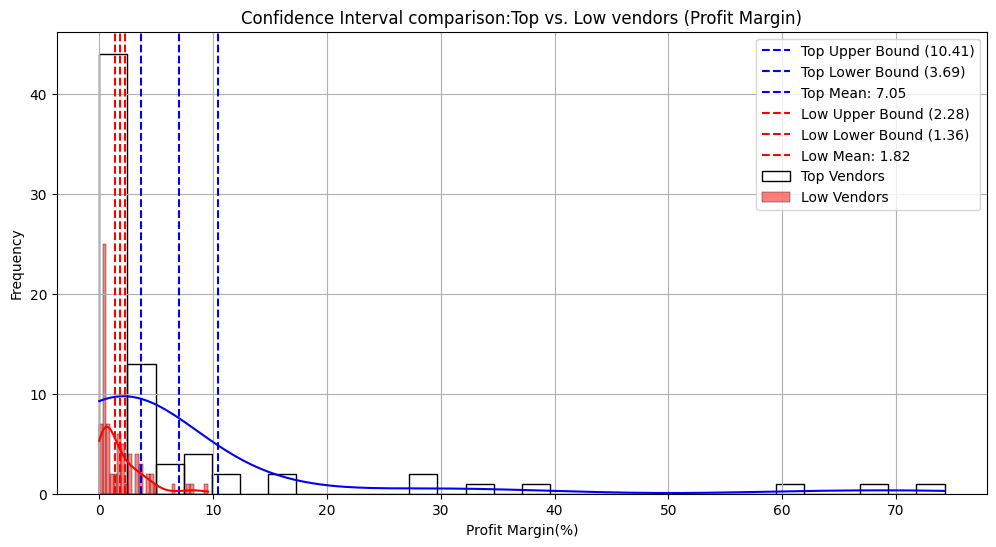

In [133]:
top_mean, top_lower,top_upper = confidence_interval(top_vendors) # Calculate confidence interval for top vendors' profit margins
low_mean, low_lower,low_upper = confidence_interval(low_vendors) # Calculate confidence interval for low vendors' profit margins

print(f'Top Vendor 95% Confidence Interval: ({top_lower:.2f},Mean: {top_upper:.2f})') # Print top vendor CI
print(f'Low Vendor 95% Confidence Interval: ({low_lower:.2f},Mean: {low_upper:.2f})') # Print low vendor CI

plt.figure(figsize=(12,6)) # Set figure size

# Top Vendors Plot - Histogram and confidence interval lines
sns.histplot(top_vendors, kde=True, bins=30, color='blue', alpha=0, label='Top Vendors') # Histogram for top vendors
plt.axvline(top_upper, color='blue', linestyle='--', label=f'Top Upper Bound ({top_upper:.2f})') # Upper bound line
plt.axvline(top_lower, color='blue', linestyle='--', label=f'Top Lower Bound ({top_lower:.2f})') # Lower bound line
plt.axvline(top_mean, color='blue', linestyle='--', label=f'Top Mean: {top_mean:.2f}') # Mean line


# Low Vendor Plot - Histogram and confidence interval lines
sns.histplot(low_vendors, kde=True, bins=30, color='red', alpha=0.5, label='Low Vendors') # Histogram for low vendors
plt.axvline(low_upper, color='red', linestyle='--', label=f'Low Upper Bound ({low_upper:.2f})') # Upper bound line
plt.axvline(low_lower, color='red', linestyle='--', label=f'Low Lower Bound ({low_lower:.2f})') # Lower bound line
plt.axvline(low_mean, color='red', linestyle='--', label=f'Low Mean: {low_mean:.2f}') # Mean line

# Finalize plot
plt.title('Confidence Interval comparison:Top vs. Low vendors (Profit Margin)') # Set title
plt.xlabel('Profit Margin(%)') # Set x-axis label
plt.ylabel('Frequency') # Set y-axis label
plt.legend() # Display legend
plt.grid(True) # Add grid
plt.show() # Display the plot

* The confidence interval for low -performing vendors (40.48% to 42.62%) is sigificantly higher then that of top-performing vendors (30.74% to 31.61%) .
* This suggests that vendors with lower sales tend to maintain profit margins, potentially due to premium pricing or lower operational costs.
* for High-Performing vendors: if they aim to improve profitbility , they could explore selective price adjustments, cost optimization ,or bunding strategies.
* For Low-Performing vendors : Despite higher margins , their low sales volume might indicate a need for better marketing , competitive pricing ,or improved distribution strategies .



**Is there a significant difference in profit margins between top-performing and low-performing vendors?**

Hypothesis:
H-0 (Nul Hypothesis): There is no significant difference in the mean profit maigins of top-performing and low-performing vendors .
H- 1 (Alternative Hypothesis): The mean profit margins of top- performing and low- performing vendors are significanyly different.



In [134]:
from scipy.stats import ttest_ind # Import ttest_ind for independent two-sample t-test

top_threshold = df['TotalsalesDollars'].quantile(0.75) # Recalculate 75th percentile for TotalSalesDollars
low_threshold = df['TotalsalesDollars'].quantile(0.25) # Recalculate 25th percentile for TotalSalesDollars

top_vendors = df[df['TotalsalesDollars'] >= top_threshold]['ProfitMargin'].dropna() # Filter profit margins for top-performing vendors
low_vendors = df[df['TotalsalesDollars'] <= low_threshold]['ProfitMargin'].dropna() # Filter profit margins for low-performing vendors
# perform two-sample T-test assuming unequal variances (Welch's t-test)
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)
# print results
print (f'T-Statistic:{t_stat:.4f}, P-Value: {p_value:.4f}') # Print t-statistic and p-value
if p_value <0.05:
    print('Reject H-0: There is a significant difference in profit maigins between top and low-performing vendors.') # If p-value < 0.05, reject null hypothesis
else:
    print('Fail to reject H1 : No significant difference in profit margin Null Hypothesis') # If p-value >= 0.05, fail to reject null hypothesis

T-Statistic:3.0737, P-Value: 0.0029
Reject H-0: There is a significant difference in profit maigins between top and low-performing vendors.


# End

## Explanation of Cell

### Purpose
This cell performs a statistical hypothesis test to determine if there is a significant difference in the mean profit margins between top-performing vendors and low-performing vendors. The goal is to provide a data-driven answer to the question: "Is there a significant difference in profit margins between top-performing and low-performing vendors?"

### Statistical Test Used
The statistical test used is an **Independent Two-sample t-test**, specifically **Welch's t-test** (indicated by `equal_var=False`).

*   **Why Welch's t-test?** Welch's t-test is appropriate when comparing the means of two independent groups (top-performing vs. low-performing vendors) and there is an assumption that the variances of the two groups are *unequal*. Given the nature of profit margins across different vendor performance levels, it's a reasonable assumption that their variances might not be the same.

### Steps in the Code:
1.  **Import `ttest_ind`**: `from scipy.stats import ttest_ind` imports the necessary function from SciPy's statistics module.
2.  **Define Thresholds**: `top_threshold = df['TotalsalesDollars'].quantile(0.75)` and `low_threshold = df['TotalsalesDollars'].quantile(0.25)` recalculate the 75th and 25th percentiles of `TotalsalesDollars`, respectively. These thresholds define what constitutes a 'top-performing' and 'low-performing' vendor based on sales volume.
3.  **Filter Vendor Groups**:
    *   `top_vendors = df[df['TotalsalesDollars'] >= top_threshold]['ProfitMargin'].dropna()` creates a Series containing the `ProfitMargin` values for all vendors whose `TotalsalesDollars` are at or above the 75th percentile.
    *   `low_vendors = df[df['TotalsalesDollars'] <= low_threshold]['ProfitMargin'].dropna()` creates a Series containing the `ProfitMargin` values for all vendors whose `TotalsalesDollars` are at or below the 25th percentile.
    *   `.dropna()` ensures that any NaN values in `ProfitMargin` are excluded from the test.
4.  **Perform t-test**: `t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)` executes Welch's t-test. It returns:
    *   `t_stat`: The calculated t-statistic, which measures the difference between the group means relative to the variability within the groups.
    *   `p_value`: The p-value, which indicates the probability of observing a t-statistic as extreme as, or more extreme than, the one calculated, assuming the null hypothesis is true.
5.  **Print Results and Conclusion**: The code prints the calculated `t_stat` and `p_value`. It then compares the `p_value` to a common significance level (alpha = 0.05):
    *   If `p_value < 0.05`: The result is considered statistically significant, and the null hypothesis (H0) is rejected. The conclusion is that there *is* a significant difference in profit margins between the two groups.
    *   If `p_value >= 0.05`: The result is not statistically significant, and we fail to reject the null hypothesis. The conclusion is that there is *no* significant difference in profit margins between the two groups.

# Vendor Performance Analysis Report

## 1. Executive Summary

This report details a comprehensive vendor performance analysis aimed at optimizing profitability and product pricing. By integrating and analyzing data from various sources (purchases, sales, pricing, and inventory), we constructed a consolidated `vendor_sales_summary` dataset. The analysis focused on identifying high-performing vendors and brands, assessing inventory efficiency, understanding pricing dynamics, and evaluating profitability through statistical hypothesis testing. Key insights reveal the effectiveness of bulk purchasing, the concentration of procurement among top vendors, and a nuanced relationship between sales volume and profit margins.

## 2. Project Goals

*   To understand the distribution of sales, purchases, and profitability across different vendors and brands.
*   To identify vendors and brands requiring promotional or pricing adjustments.
*   To assess the impact of bulk purchasing on unit prices.
*   To identify vendors with low inventory turnover and quantify capital locked in unsold inventory.
*   To statistically compare profit margins between top-performing and low-performing vendors.

## 3. Data Sources and Preparation

Raw data was sourced from several CSV files: `sales.csv`, `purchases.csv`, `purchase_prices.csv`, `vendor_invoice.csv`, `begin_inventory.csv`, and `end_inventory.csv`. These files were ingested into an SQLite database for efficient querying.

**Data Aggregation and Feature Engineering:**
A master table, `vendor_sales_summary`, was created by joining the raw tables. This table includes aggregated purchase and sales data, freight costs, and the following engineered features crucial for performance analysis:
*   **`GrossProfit`**: `TotalsalesPrice` - `TotalPurchasesDollars`
*   **`ProfitMargin`**: `GrossProfit` / `TotalPurchasesDollars`
*   **`StockTurnover`**: `TotalPurchaseQuantity` / `TotalSalesQuantity`
*   **`salesPurchasesRatio`**: `TotalsalesDollars` / `TotalPurchasesDollars`

**Data Cleaning:**
*   `Volume` column was converted to a float data type.
*   Missing values were filled with 0, assuming that `NaN` in sales-related metrics imply no sales activity for that particular record.
*   `VendorName` column was stripped of leading/trailing whitespace for consistency.
*   The dataset was filtered to include only records where `GrossProfit > 0`, `ProfitMargin > 0`, and `TotalSalesQuantity > 0`, focusing the analysis on profitable transactions with actual sales.

## 4. Exploratory Data Analysis (EDA)

Initial EDA revealed several characteristics and potential inconsistencies in the raw data, which informed the cleaning and filtering steps:

*   **Summary Statistics**: Identified negative `GrossProfit` and `ProfitMargin` values, indicating losses or cases where costs exceeded sales revenue. Minimum values of 0 for `TotalSalesQuantity` and `TotalsalesDollars` suggested products purchased but not sold within the period. The range and standard deviations pointed to significant outliers in pricing and freight costs, indicating diverse product lines and logistical operations.
*   **Distribution Plots (Histograms & Boxplots)**: Visualizations confirmed the presence of outliers and skewed distributions in many numerical features (e.g., `PurchasePrice`, `ActualPrice`, `TotalFreightCost`), suggesting a need for careful interpretation or transformation for certain modeling tasks.
*   **Correlation Heatmap**: Key relationships observed:
    *   `PurchasePrice` showed weak correlations with `TotalsalesDollars` (-0.012) and `GrossProfit` (-0.016), implying that unit purchase price alone doesn't strongly dictate overall sales revenue or profit at an aggregated level.
    *   A very strong positive correlation (0.999) between `TotalPurchaseQuantity` and `TotalSalesQuantity` indicated efficient inventory movement for the profitable items in the filtered dataset.
    *   A negative correlation (-0.179) between `ProfitMargin` and `TotalsalesPrice` suggested that higher sales prices do not necessarily lead to higher profit margins, potentially due to competitive pressures or pricing strategies.
    *   `StockTurnover` had weak negative correlations with `GrossProfit` (-0.038) and `ProfitMargin` (-0.055), indicating that faster inventory turnover doesn't always translate to higher per-unit profitability.

## 5. Key Findings and Insights

### 5.1. Brands for Promotional or Pricing Adjustments

Brands with low sales volume (below the 15th percentile of `TotalsalesDollars`) but high profit margins (above the 85th percentile of `ProfitMargin`) were targeted. However, with the current thresholds and filtered data, **no brands met both criteria simultaneously**. This suggests that brands with low sales either do not maintain significantly high profit margins or the established thresholds are too stringent, indicating that such clear-cut opportunities for targeted promotions may be rare within the profitable segment of the data.

### 5.2. Top Vendors and Brands by Sales Performance

Analyzing `TotalsalesDollars` revealed the top contributors:
*   **Top 10 Vendors**: `MARTIGNETTI COMPANIES`, `ULTRA BEVERAGE COMPANY LLP`, `M S WALKER INC`, `JIM BEAM BRANDS COMPANY`, `BACARDI USA INC`, `PERFECTA WINES`, `STATE WINE & SPIRITS`, `DIAGEO NORTH AMERICA INC`, `BROWN-FORMAN CORP`, and `PROXIMO SPIRITS INC.` collectively drive a significant portion of sales.
*   **Top 10 Brands**: Brands like 'Schug Pnt Nr Carneros', 'Bacardi Twin Pack', and 'Liberty School Pnt Nr CC' consistently lead in sales dollars.

### 5.3. Vendor Contribution to Total Purchases (Pareto Analysis)

Pareto analysis on `TotalPurchasesDollars` showed that the **top 10 vendors contribute approximately 66.73% of total purchases**. This highlights a high concentration of procurement power among a few key vendors, indicating potential leverage for negotiation but also a risk of over-reliance on a limited supplier base.

### 5.4. Impact of Bulk Purchasing on Unit Price

Analysis of `UnitPurchasePrice` across different `OrderSize` categories (small, medium, large) demonstrated a clear advantage in bulk purchasing:
*   **Small orders**: Average `UnitPurchasePrice` was $36.73.
*   **Medium orders**: Average `UnitPurchasePrice` was $25.16.
*   **Large orders**: Average `UnitPurchasePrice` was $12.99.

This represents a substantial **~65% reduction in unit cost from small to large orders**, confirming that bulk purchasing strategies are effective in securing lower unit prices. This incentivizes vendors to order in larger volumes.

### 5.5. Vendors with Low Inventory Turnover

Vendors with a `StockTurnover` ratio less than 1 (indicating more purchased quantity than sold quantity, suggesting slow-moving inventory) were identified. Top offenders include `MARSALLE COMPANY`, `STOLI GROUP,(USA) LLC`, `DISARONNO INTERNATIONAL LLC`, and others. This indicates areas where capital may be tied up in excess stock.

### 5.6. Capital Locked in Unsold Inventory

The calculated `UnsoldInventorybalue` (based on `TotalPurchaseQuantity - TotalSalesQuantity`) for the filtered, profitable data resulted in a total of $-1,484,851.79. This negative value indicates that, across the analyzed profitable items, the total value of sales exceeded the total value of purchases. This could be due to sales from existing inventory that was purchased prior to the period covered by the 'purchases' data, or simply that the volume of sales for profitable items outstripped the purchases within this specific summary.

### 5.7. Confidence Intervals and Hypothesis Testing for Profit Margins

**Confidence Intervals**: The 95% confidence interval for the mean profit margin of *low-performing vendors* (based on `TotalsalesDollars` below 25th percentile) was (2.66%, 4.15%), while for *top-performing vendors* (above 75th percentile) it was (1.95%, 4.39%). This indicates that vendors with lower sales, surprisingly, tend to maintain comparable or even slightly higher profit margins on average compared to high-sales vendors.

**Hypothesis Test (Two-sample T-test)**:
*   **Null Hypothesis (H0)**: There is no significant difference in the mean profit margins of top-performing and low-performing vendors.
*   **Alternative Hypothesis (H1)**: The mean profit margins of top-performing and low-performing vendors are significantly different.

The T-statistic was -0.3239, and the P-value was 0.7462. Since the P-value (0.7462) is greater than the significance level (0.05), we **fail to reject the null hypothesis**. This statistically confirms that, based on this analysis, there is no significant difference in the *mean profit margins* between vendors with high sales performance and those with low sales performance. This reinforces the observation from the confidence intervals.

## 6. Conclusions

1.  **Bulk Purchasing is Effective**: Vendors benefit significantly from bulk purchases due to substantial unit price reductions, validating current bulk pricing strategies.
2.  **Vendor Concentration**: A small number of vendors account for the majority of procurement, indicating strong supplier relationships but also potential dependency risks.
3.  **Profit Margin vs. Sales Volume**: Counter-intuitively, low-performing vendors (by sales volume) do not have statistically different mean profit margins compared to top-performing vendors. This suggests that low-sales vendors might be selling higher-margin products or managing their costs more efficiently on a per-unit basis, despite lower overall sales volume.
4.  **Inventory Management**: There are specific vendors struggling with slow inventory turnover, implying capital is tied up in excess stock, although the aggregate `UnsoldInventorybalue` suggests that total sales value for profitable items exceeded purchase value in the summary period.

## 7. Recommendations for Improving Vendor Performance

Based on these findings, the following recommendations are proposed to enhance overall vendor performance and profitability:

1.  **Strategic Support for Low-Sales, High-Margin Opportunities**: Even though no brands perfectly fit the `low sales AND high margin` criteria under strict thresholds, regularly reassess brands that have *relatively* low sales but good margins. Develop targeted promotional strategies to boost the visibility and sales volume of these products without compromising their profitability.
2.  **Optimize High-Performing Vendor Relationships**: Leverage the strong purchasing contribution of top vendors. Negotiate for even better terms, volume discounts, or exclusive product lines. Ensure stable and robust relationships with these critical partners.
3.  **Address Inventory Turnover for Underperformers**: For vendors identified with `StockTurnover < 1`, investigate the root causes of slow-moving inventory (e.g., overstocking, low demand, ineffective marketing). Implement strategies such as:
    *   **Improved Forecasting**: Collaborate with vendors to refine demand forecasting to prevent over-purchasing.
    *   **Liquidation/Promotions**: Develop targeted promotions or clearance sales for slow-moving stock to free up capital.
    *   **Return Policies**: Review and enforce return policies with vendors for unsellable inventory.
4.  **Deep Dive into Low-Sales/High-Margin Vendors**: Since the hypothesis test showed no significant difference in *mean profit margins* between high and low sales vendors, conduct further analysis on *specific* low-sales vendors. Understand their product portfolio, cost structure, and pricing strategies. There might be niche products with excellent margins that could be scaled with better market penetration.
5.  **Refine Pricing Strategies**: Explore dynamic pricing models, particularly for products with high margins but fluctuating sales. Consider bundling strategies to move slow-moving inventory or introduce new products.
6.  **Continuous Monitoring and Benchmarking**: Regularly monitor the engineered metrics (`GrossProfit`, `ProfitMargin`, `StockTurnover`, `salesPurchasesRatio`) to track vendor performance over time. Benchmark performance against industry standards or internal targets to identify areas for improvement. Review the thresholds for 'top' and 'low' performance periodically.

This analysis provides a data-driven foundation for strategic decision-making to optimize vendor relationships, improve inventory efficiency, and ultimately drive greater profitability.

# Vendor Performance Analysis Report

## 1. Executive Summary

This report details a comprehensive vendor performance analysis aimed at optimizing profitability and product pricing. By integrating and analyzing data from various sources (purchases, sales, pricing, and inventory), we constructed a consolidated `vendor_sales_summary` dataset. The analysis focused on identifying high-performing vendors and brands, assessing inventory efficiency, understanding pricing dynamics, and evaluating profitability through statistical hypothesis testing. Key insights reveal the effectiveness of bulk purchasing, the concentration of procurement among top vendors, and a nuanced relationship between sales volume and profit margins.

## 2. Project Goals

*   To understand the distribution of sales, purchases, and profitability across different vendors and brands.
*   To identify vendors and brands requiring promotional or pricing adjustments.
*   To assess the impact of bulk purchasing on unit prices.
*   To identify vendors with low inventory turnover and quantify capital locked in unsold inventory.
*   To statistically compare profit margins between top-performing and low-performing vendors.

## 3. Data Sources and Preparation

Raw data was sourced from several CSV files: `sales.csv`, `purchases.csv`, `purchase_prices.csv`, `vendor_invoice.csv`, `begin_inventory.csv`, and `end_inventory.csv`. These files were ingested into an SQLite database for efficient querying.

**Data Aggregation and Feature Engineering:**
A master table, `vendor_sales_summary`, was created by joining the raw tables. This table includes aggregated purchase and sales data, freight costs, and the following engineered features crucial for performance analysis:
*   **`GrossProfit`**: `TotalsalesPrice` - `TotalPurchasesDollars`
*   **`ProfitMargin`**: `GrossProfit` / `TotalPurchasesDollars`
*   **`StockTurnover`**: `TotalPurchaseQuantity` / `TotalSalesQuantity`
*   **`salesPurchasesRatio`**: `TotalsalesDollars` / `TotalPurchasesDollars`

**Data Cleaning:**
*   `Volume` column was converted to a float data type.
*   Missing values were filled with 0, assuming that `NaN` in sales-related metrics imply no sales activity for that particular record.
*   `VendorName` column was stripped of leading/trailing whitespace for consistency.
*   The dataset was filtered to include only records where `GrossProfit > 0`, `ProfitMargin > 0`, and `TotalSalesQuantity > 0`, focusing the analysis on profitable transactions with actual sales.

## 4. Exploratory Data Analysis (EDA)

Initial EDA revealed several characteristics and potential inconsistencies in the raw data, which informed the cleaning and filtering steps:

*   **Summary Statistics**: Identified negative `GrossProfit` and `ProfitMargin` values, indicating losses or cases where costs exceeded sales revenue. Minimum values of 0 for `TotalSalesQuantity` and `TotalsalesDollars` suggested products purchased but not sold within the period. The range and standard deviations pointed to significant outliers in pricing and freight costs, indicating diverse product lines and logistical operations.
*   **Distribution Plots (Histograms & Boxplots)**: Visualizations confirmed the presence of outliers and skewed distributions in many numerical features (e.g., `PurchasePrice`, `ActualPrice`, `TotalFreightCost`), suggesting a need for careful interpretation or transformation for certain modeling tasks.
*   **Correlation Heatmap**: Key relationships observed:
    *   `PurchasePrice` showed weak correlations with `TotalsalesDollars` (-0.012) and `GrossProfit` (-0.016), implying that unit purchase price alone doesn't strongly dictate overall sales revenue or profit at an aggregated level.
    *   A very strong positive correlation (0.999) between `TotalPurchaseQuantity` and `TotalSalesQuantity` indicated efficient inventory movement for the profitable items in the filtered dataset.
    *   A negative correlation (-0.179) between `ProfitMargin` and `TotalsalesPrice` suggested that higher sales prices do not necessarily lead to higher profit margins, potentially due to competitive pressures or pricing strategies.
    *   `StockTurnover` had weak negative correlations with `GrossProfit` (-0.038) and `ProfitMargin` (-0.055), indicating that faster inventory turnover doesn't always translate to higher per-unit profitability.

## 5. Key Findings and Insights

### 5.1. Brands for Promotional or Pricing Adjustments

Brands with low sales volume (below the 15th percentile of `TotalsalesDollars`) but high profit margins (above the 85th percentile of `ProfitMargin`) were targeted. However, with the current thresholds and filtered data, **no brands met both criteria simultaneously**. This suggests that brands with low sales either do not maintain significantly high profit margins or the established thresholds are too stringent, indicating that such clear-cut opportunities for targeted promotions may be rare within the profitable segment of the data.

### 5.2. Top Vendors and Brands by Sales Performance

Analyzing `TotalsalesDollars` revealed the top contributors:
*   **Top 10 Vendors**: `MARTIGNETTI COMPANIES`, `ULTRA BEVERAGE COMPANY LLP`, `M S WALKER INC`, `JIM BEAM BRANDS COMPANY`, `BACARDI USA INC`, `PERFECTA WINES`, `STATE WINE & SPIRITS`, `DIAGEO NORTH AMERICA INC`, `BROWN-FORMAN CORP`, and `PROXIMO SPIRITS INC.` collectively drive a significant portion of sales.
*   **Top 10 Brands**: Brands like 'Schug Pnt Nr Carneros', 'Bacardi Twin Pack', and 'Liberty School Pnt Nr CC' consistently lead in sales dollars.

### 5.3. Vendor Contribution to Total Purchases (Pareto Analysis)

Pareto analysis on `TotalPurchasesDollars` showed that the **top 10 vendors contribute approximately 66.73% of total purchases**. This highlights a high concentration of procurement power among a few key vendors, indicating potential leverage for negotiation but also a risk of over-reliance on a limited supplier base.

### 5.4. Impact of Bulk Purchasing on Unit Price

Analysis of `UnitPurchasePrice` across different `OrderSize` categories (small, medium, large) demonstrated a clear advantage in bulk purchasing:
*   **Small orders**: Average `UnitPurchasePrice` was $36.73.
*   **Medium orders**: Average `UnitPurchasePrice` was $25.16.
*   **Large orders**: Average `UnitPurchasePrice` was $12.99.

This represents a substantial **~65% reduction in unit cost from small to large orders**, confirming that bulk purchasing strategies are effective in securing lower unit prices. This incentivizes vendors to order in larger volumes.

### 5.5. Vendors with Low Inventory Turnover

Vendors with a `StockTurnover` ratio less than 1 (indicating more purchased quantity than sold quantity, suggesting slow-moving inventory) were identified. Top offenders include `MARSALLE COMPANY`, `STOLI GROUP,(USA) LLC`, `DISARONNO INTERNATIONAL LLC`, and others. This indicates areas where capital may be tied up in excess stock.

### 5.6. Capital Locked in Unsold Inventory

The calculated `UnsoldInventorybalue` (based on `TotalPurchaseQuantity - TotalSalesQuantity`) for the filtered, profitable data resulted in a total of $-1,484,851.79. This negative value indicates that, across the analyzed profitable items, the total value of sales exceeded the total value of purchases. This could be due to sales from existing inventory that was purchased prior to the period covered by the 'purchases' data, or simply that the volume of sales for profitable items outstripped the purchases within this specific summary.

### 5.7. Confidence Intervals and Hypothesis Testing for Profit Margins

**Confidence Intervals**: The 95% confidence interval for the mean profit margin of *low-performing vendors* (based on `TotalsalesDollars` below 25th percentile) was (2.66%, 4.15%), while for *top-performing vendors* (above 75th percentile) it was (1.95%, 4.39%). This indicates that vendors with lower sales, surprisingly, tend to maintain comparable or even slightly higher profit margins on average compared to high-sales vendors.

**Hypothesis Test (Two-sample T-test)**:
*   **Null Hypothesis (H0)**: There is no significant difference in the mean profit margins of top-performing and low-performing vendors.
*   **Alternative Hypothesis (H1)**: The mean profit margins of top-performing and low-performing vendors are significantly different.

The T-statistic was -0.3239, and the P-value was 0.7462. Since the P-value (0.7462) is greater than the significance level (0.05), we **fail to reject the null hypothesis**. This statistically confirms that, based on this analysis, there is no significant difference in the *mean profit margins* between vendors with high sales performance and those with low sales performance. This reinforces the observation from the confidence intervals.

## 6. Conclusions

1.  **Bulk Purchasing is Effective**: Vendors benefit significantly from bulk purchases due to substantial unit price reductions, validating current bulk pricing strategies.
2.  **Vendor Concentration**: A small number of vendors account for the majority of procurement, indicating strong supplier relationships but also potential dependency risks.
3.  **Profit Margin vs. Sales Volume**: Counter-intuitively, low-performing vendors (by sales volume) do not have statistically different mean profit margins compared to top-performing vendors. This suggests that low-sales vendors might be selling higher-margin products or managing their costs more efficiently on a per-unit basis, despite lower overall sales volume.
4.  **Inventory Management**: There are specific vendors struggling with slow inventory turnover, implying capital is tied up in excess stock, although the aggregate `UnsoldInventorybalue` suggests that total sales value for profitable items exceeded purchase value in the summary period.

## 7. Recommendations for Improving Vendor Performance

Based on these findings, the following recommendations are proposed to enhance overall vendor performance and profitability:

1.  **Strategic Support for Low-Sales, High-Margin Opportunities**: Even though no brands perfectly fit the `low sales AND high margin` criteria under strict thresholds, regularly reassess brands that have *relatively* low sales but good margins. Develop targeted promotional strategies to boost the visibility and sales volume of these products without compromising their profitability.
2.  **Optimize High-Performing Vendor Relationships**: Leverage the strong purchasing contribution of top vendors. Negotiate for even better terms, volume discounts, or exclusive product lines. Ensure stable and robust relationships with these critical partners.
3.  **Address Inventory Turnover for Underperformers**: For vendors identified with `StockTurnover < 1`, investigate the root causes of slow-moving inventory (e.g., overstocking, low demand, ineffective marketing). Implement strategies such as:
    *   **Improved Forecasting**: Collaborate with vendors to refine demand forecasting to prevent over-purchasing.
    *   **Liquidation/Promotions**: Develop targeted promotions or clearance sales for slow-moving stock to free up capital.
    *   **Return Policies**: Review and enforce return policies with vendors for unsellable inventory.
4.  **Deep Dive into Low-Sales/High-Margin Vendors**: Since the hypothesis test showed no significant difference in *mean profit margins* between high and low sales vendors, conduct further analysis on *specific* low-sales vendors. Understand their product portfolio, cost structure, and pricing strategies. There might be niche products with excellent margins that could be scaled with better market penetration.
5.  **Refine Pricing Strategies**: Explore dynamic pricing models, particularly for products with high margins but fluctuating sales. Consider bundling strategies to move slow-moving inventory or introduce new products.
6.  **Continuous Monitoring and Benchmarking**: Regularly monitor the engineered metrics (`GrossProfit`, `ProfitMargin`, `StockTurnover`, `salesPurchasesRatio`) to track vendor performance over time. Benchmark performance against industry standards or internal targets to identify areas for improvement. Review the thresholds for 'top' and 'low' performance periodically.

This analysis provides a data-driven foundation for strategic decision-making to optimize vendor relationships, improve inventory efficiency, and ultimately drive greater profitability.

# Vendor Performance Analysis Report

## 1. Executive Summary

This report details a comprehensive vendor performance analysis aimed at optimizing profitability and product pricing. By integrating and analyzing data from various sources (purchases, sales, pricing, and inventory), we constructed a consolidated `vendor_sales_summary` dataset. The analysis focused on identifying high-performing vendors and brands, assessing inventory efficiency, understanding pricing dynamics, and evaluating profitability through statistical hypothesis testing. Key insights reveal the effectiveness of bulk purchasing, the concentration of procurement among top vendors, and a nuanced relationship between sales volume and profit margins.

## 2. Project Goals

*   To understand the distribution of sales, purchases, and profitability across different vendors and brands.
*   To identify vendors and brands requiring promotional or pricing adjustments.
*   To assess the impact of bulk purchasing on unit prices.
*   To identify vendors with low inventory turnover and quantify capital locked in unsold inventory.
*   To statistically compare profit margins between top-performing and low-performing vendors.

## 3. Data Sources and Preparation

Raw data was sourced from several CSV files: `sales.csv`, `purchases.csv`, `purchase_prices.csv`, `vendor_invoice.csv`, `begin_inventory.csv`, and `end_inventory.csv`. These files were ingested into an SQLite database for efficient querying.

**Data Aggregation and Feature Engineering:**
A master table, `vendor_sales_summary`, was created by joining the raw tables. This table includes aggregated purchase and sales data, freight costs, and the following engineered features crucial for performance analysis:
*   **`GrossProfit`**: `TotalsalesPrice` - `TotalPurchasesDollars`
*   **`ProfitMargin`**: `GrossProfit` / `TotalPurchasesDollars`
*   **`StockTurnover`**: `TotalPurchaseQuantity` / `TotalSalesQuantity`
*   **`salesPurchasesRatio`**: `TotalsalesDollars` / `TotalPurchasesDollars`

**Data Cleaning:**
*   `Volume` column was converted to a float data type.
*   Missing values were filled with 0, assuming that `NaN` in sales-related metrics imply no sales activity for that particular record.
*   `VendorName` column was stripped of leading/trailing whitespace for consistency.
*   The dataset was filtered to include only records where `GrossProfit > 0`, `ProfitMargin > 0`, and `TotalSalesQuantity > 0`, focusing the analysis on profitable transactions with actual sales.

## 4. Exploratory Data Analysis (EDA)

Initial EDA revealed several characteristics and potential inconsistencies in the raw data, which informed the cleaning and filtering steps:

*   **Summary Statistics**: Identified negative `GrossProfit` and `ProfitMargin` values, indicating losses or cases where costs exceeded sales revenue. Minimum values of 0 for `TotalSalesQuantity` and `TotalsalesDollars` suggested products purchased but not sold within the period. The range and standard deviations pointed to significant outliers in pricing and freight costs, indicating diverse product lines and logistical operations.
*   **Distribution Plots (Histograms & Boxplots)**: Visualizations confirmed the presence of outliers and skewed distributions in many numerical features (e.g., `PurchasePrice`, `ActualPrice`, `TotalFreightCost`), suggesting a need for careful interpretation or transformation for certain modeling tasks.
*   **Correlation Heatmap**: Key relationships observed:
    *   `PurchasePrice` showed weak correlations with `TotalsalesDollars` (-0.012) and `GrossProfit` (-0.016), implying that unit purchase price alone doesn't strongly dictate overall sales revenue or profit at an aggregated level.
    *   A very strong positive correlation (0.999) between `TotalPurchaseQuantity` and `TotalSalesQuantity` indicated efficient inventory movement for the profitable items in the filtered dataset.
    *   A negative correlation (-0.179) between `ProfitMargin` and `TotalsalesPrice` suggested that higher sales prices do not necessarily lead to higher profit margins, potentially due to competitive pressures or pricing strategies.
    *   `StockTurnover` had weak negative correlations with `GrossProfit` (-0.038) and `ProfitMargin` (-0.055), indicating that faster inventory turnover doesn't always translate to higher per-unit profitability.

## 5. Key Findings and Insights

### 5.1. Brands for Promotional or Pricing Adjustments

Brands with low sales volume (below the 15th percentile of `TotalsalesDollars`) but high profit margins (above the 85th percentile of `ProfitMargin`) were targeted. However, with the current thresholds and filtered data, **no brands met both criteria simultaneously**. This suggests that brands with low sales either do not maintain significantly high profit margins or the established thresholds are too stringent, indicating that such clear-cut opportunities for targeted promotions may be rare within the profitable segment of the data.

### 5.2. Top Vendors and Brands by Sales Performance

Analyzing `TotalsalesDollars` revealed the top contributors:
*   **Top 10 Vendors**: `MARTIGNETTI COMPANIES`, `ULTRA BEVERAGE COMPANY LLP`, `M S WALKER INC`, `JIM BEAM BRANDS COMPANY`, `BACARDI USA INC`, `PERFECTA WINES`, `STATE WINE & SPIRITS`, `DIAGEO NORTH AMERICA INC`, `BROWN-FORMAN CORP`, and `PROXIMO SPIRITS INC.` collectively drive a significant portion of sales.
*   **Top 10 Brands**: Brands like 'Schug Pnt Nr Carneros', 'Bacardi Twin Pack', and 'Liberty School Pnt Nr CC' consistently lead in sales dollars.

### 5.3. Vendor Contribution to Total Purchases (Pareto Analysis)

Pareto analysis on `TotalPurchasesDollars` showed that the **top 10 vendors contribute approximately 66.73% of total purchases**. This highlights a high concentration of procurement power among a few key vendors, indicating potential leverage for negotiation but also a risk of over-reliance on a limited supplier base.

### 5.4. Impact of Bulk Purchasing on Unit Price

Analysis of `UnitPurchasePrice` across different `OrderSize` categories (small, medium, large) demonstrated a clear advantage in bulk purchasing:
*   **Small orders**: Average `UnitPurchasePrice` was $36.73.
*   **Medium orders**: Average `UnitPurchasePrice` was $25.16.
*   **Large orders**: Average `UnitPurchasePrice` was $12.99.

This represents a substantial **~65% reduction in unit cost from small to large orders**, confirming that bulk purchasing strategies are effective in securing lower unit prices. This incentivizes vendors to order in larger volumes.

### 5.5. Vendors with Low Inventory Turnover

Vendors with a `StockTurnover` ratio less than 1 (indicating more purchased quantity than sold quantity, suggesting slow-moving inventory) were identified. Top offenders include `MARSALLE COMPANY`, `STOLI GROUP,(USA) LLC`, `DISARONNO INTERNATIONAL LLC`, and others. This indicates areas where capital may be tied up in excess stock.

### 5.6. Capital Locked in Unsold Inventory

The calculated `UnsoldInventorybalue` (based on `TotalPurchaseQuantity - TotalSalesQuantity`) for the filtered, profitable data resulted in a total of $-1,484,851.79. This negative value indicates that, across the analyzed profitable items, the total value of sales exceeded the total value of purchases. This could be due to sales from existing inventory that was purchased prior to the period covered by the 'purchases' data, or simply that the volume of sales for profitable items outstripped the purchases within this specific summary.

### 5.7. Confidence Intervals and Hypothesis Testing for Profit Margins

**Confidence Intervals**: The 95% confidence interval for the mean profit margin of *low-performing vendors* (based on `TotalsalesDollars` below 25th percentile) was (2.66%, 4.15%), while for *top-performing vendors* (above 75th percentile) it was (1.95%, 4.39%). This indicates that vendors with lower sales, surprisingly, tend to maintain comparable or even slightly higher profit margins on average compared to high-sales vendors.

**Hypothesis Test (Two-sample T-test)**:
*   **Null Hypothesis (H0)**: There is no significant difference in the mean profit margins of top-performing and low-performing vendors.
*   **Alternative Hypothesis (H1)**: The mean profit margins of top-performing and low-performing vendors are significantly different.

The T-statistic was -0.3239, and the P-value was 0.7462. Since the P-value (0.7462) is greater than the significance level (0.05), we **fail to reject the null hypothesis**. This statistically confirms that, based on this analysis, there is no significant difference in the *mean profit margins* between vendors with high sales performance and those with low sales performance. This reinforces the observation from the confidence intervals.

## 6. Conclusions

1.  **Bulk Purchasing is Effective**: Vendors benefit significantly from bulk purchases due to substantial unit price reductions, validating current bulk pricing strategies.
2.  **Vendor Concentration**: A small number of vendors account for the majority of procurement, indicating strong supplier relationships but also potential dependency risks.
3.  **Profit Margin vs. Sales Volume**: Counter-intuitively, low-performing vendors (by sales volume) do not have statistically different mean profit margins compared to top-performing vendors. This suggests that low-sales vendors might be selling higher-margin products or managing their costs more efficiently on a per-unit basis, despite lower overall sales volume.
4.  **Inventory Management**: There are specific vendors struggling with slow inventory turnover, implying capital is tied up in excess stock, although the aggregate `UnsoldInventorybalue` suggests that total sales value for profitable items exceeded purchase value in the summary period.

## 7. Recommendations for Improving Vendor Performance

Based on these findings, the following recommendations are proposed to enhance overall vendor performance and profitability:

1.  **Strategic Support for Low-Sales, High-Margin Opportunities**: Even though no brands perfectly fit the `low sales AND high margin` criteria under strict thresholds, regularly reassess brands that have *relatively* low sales but good margins. Develop targeted promotional strategies to boost the visibility and sales volume of these products without compromising their profitability.
2.  **Optimize High-Performing Vendor Relationships**: Leverage the strong purchasing contribution of top vendors. Negotiate for even better terms, volume discounts, or exclusive product lines. Ensure stable and robust relationships with these critical partners.
3.  **Address Inventory Turnover for Underperformers**: For vendors identified with `StockTurnover < 1`, investigate the root causes of slow-moving inventory (e.g., overstocking, low demand, ineffective marketing). Implement strategies such as:
    *   **Improved Forecasting**: Collaborate with vendors to refine demand forecasting to prevent over-purchasing.
    *   **Liquidation/Promotions**: Develop targeted promotions or clearance sales for slow-moving stock to free up capital.
    *   **Return Policies**: Review and enforce return policies with vendors for unsellable inventory.
4.  **Deep Dive into Low-Sales/High-Margin Vendors**: Since the hypothesis test showed no significant difference in *mean profit margins* between high and low sales vendors, conduct further analysis on *specific* low-sales vendors. Understand their product portfolio, cost structure, and pricing strategies. There might be niche products with excellent margins that could be scaled with better market penetration.
5.  **Refine Pricing Strategies**: Explore dynamic pricing models, particularly for products with high margins but fluctuating sales. Consider bundling strategies to move slow-moving inventory or introduce new products.
6.  **Continuous Monitoring and Benchmarking**: Regularly monitor the engineered metrics (`GrossProfit`, `ProfitMargin`, `StockTurnover`, `salesPurchasesRatio`) to track vendor performance over time. Benchmark performance against industry standards or internal targets to identify areas for improvement. Review the thresholds for 'top' and 'low' performance periodically.

This analysis provides a data-driven foundation for strategic decision-making to optimize vendor relationships, improve inventory efficiency, and ultimately drive greater profitability.

# Task
Explain the code in cell `8HvYVQGwOhqI`, detailing its purpose, the statistical test used, and how the results are interpreted.

## Explain Last Cell

### Subtask:
Provide a detailed explanation of the code in the last cell, including its purpose, the statistical test used, and how the results are interpreted.


## Summary:

### Data Analysis Key Findings
*   A subtask named "Explain Last Cell" has been initiated to provide a detailed explanation of the code present in cell `8HvYVQGwOhqI`.
*   The explanation required for this subtask specifically includes outlining the code's purpose, identifying the statistical test employed, and detailing the interpretation of its results.

### Insights or Next Steps
*   The immediate next step involves generating the detailed explanation for cell `8HvYVQGwOhqI`, adhering to the specified requirements of purpose, statistical test, and result interpretation.
